In [2]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
import nmrglue as ng
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

In [3]:
## Name model, and load and preprocess dataset

In [4]:
# Define number of epochs used later in training
num_epochs = 500

# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = "Transformer_AdjustSNR_21Met" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [4]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra400 = np.load('Dataset21_400MHz_AdjustSNR_Spec.npy')
spectra100 = np.load('Dataset21_100MHz_AdjustSNR_Spec.npy')
conc1 = np.load('Dataset21_AdjustSNR_Conc.npy')

# Load validation dataset
#spectraVal400 = np.load('Dataset21_400MHz_AdjustSNR_Val_Spec.npy')
#spectraVal100 = np.load('Dataset21_100MHz_AdjustSNR_Val_Spec.npy')
#pectraValConc = np.load('Dataset21_AdjustSNR_Val_Conc.npy')

# Load representative validation spectra
#RepSpectra400 = np.load("Dataset21_400MHz_AdjustSNR_RepresentativeExamples_Spectra.npy")
#RepSpectra100 = np.load("Dataset21_100MHz_AdjustSNR_RepresentativeExamples_Spectra.npy")
#RepConc = np.load("Dataset21_AdjustSNR_RepresentativeExamples_Concentrations.npy")
#RepSpecNames = np.load("Dataset21_AdjustSNR_RepresentativeExamples_VariableNames.npy")

In [5]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [6]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra100, spectra400, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
#spectraVal100 = torch.tensor(spectraVal100).float().to(device)   # These spectra are the 5000 spectra generated like the training dataset
#RepSpectra100 = torch.tensor(RepSpectra100).float().to(device)   # These spectra are the representative example spectra

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
#spectraVal400 = torch.tensor(spectraVal400).float().to(device)
#RepSpectra400 = torch.tensor(RepSpectra400).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 32, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 32, shuffle=True)

In [8]:
del X_train
del X_test
del y_train
del y_test

In [6]:
import torch.nn.functional as F

class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(d_model, input_dim)

    def forward(self, x):
        # Binning
        batch_size, seq_length = x.size()
        num_bins = seq_length // self.input_dim
        x = x.view(batch_size, num_bins, self.input_dim)  # (batch_size, num_bins, input_dim)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, num_bins, d_model)
        
        # Transformer Encoder
        x = x.permute(1, 0, 2)  # (num_bins, batch_size, d_model)
        x = self.transformer_encoder(x)  # (num_bins, batch_size, d_model)
        x = x.permute(1, 0, 2)  # (batch_size, num_bins, d_model)
        
        # Decoding
        x = self.decoder(x)  # (batch_size, num_bins, input_dim)
        
        # Reconstruct original sequence
        x = x.view(batch_size, -1)  # (batch_size, seq_length)
        return x

# Parameters
input_dim = 1000  # Size of each bin
d_model = 512     # Embedding dimension
nhead = 8         # Number of attention heads
num_encoder_layers = 6  # Number of transformer encoder layers
dim_feedforward = 2048  # Feedforward dimension
dropout = 0.1     # Dropout rate

# Initialize the model
model = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)


/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [6]:
def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            #inputs = inputs.unsqueeze(1)
            #targets = targets.unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                #inputs = inputs.unsqueeze(1)
                #targets = targets.unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)

        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            # Save model when test loss improves
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)

    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [11]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/500], Train Loss: 92.4902, Test Loss: 1.0614
Epoch [2/500], Train Loss: 4.3985, Test Loss: 1.0502
Epoch [3/500], Train Loss: 3.9277, Test Loss: 0.9001
Epoch [4/500], Train Loss: 3.6468, Test Loss: 0.8709
Epoch [5/500], Train Loss: 3.4296, Test Loss: 0.7646
Epoch [6/500], Train Loss: 2.6171, Test Loss: 0.4830
Epoch [7/500], Train Loss: 1.8839, Test Loss: 0.3668
Epoch [8/500], Train Loss: 1.4769, Test Loss: 0.2804
Epoch [9/500], Train Loss: 1.1477, Test Loss: 0.2149
Epoch [10/500], Train Loss: 0.9070, Test Loss: 0.1609
Epoch [11/500], Train Loss: 0.7484, Test Loss: 0.1305
Epoch [12/500], Train Loss: 0.6275, Test Loss: 0.1113
Epoch [13/500], Train Loss: 0.5440, Test Loss: 0.0977
Epoch [14/500], Train Loss: 0.4798, Test Loss: 0.0832
Epoch [15/500], Train Loss: 0.4238, Test Loss: 0.0749
Epoch [16/500], Train Loss: 0.3795, Test Loss: 0.0641
Epoch [17/500], Train Loss: 0.3397, Test Loss: 0.0591
Epoch [18/500], Train Loss: 0.3086, Test

Epoch [151/500], Train Loss: 4.1806, Test Loss: 1.0473
Epoch [152/500], Train Loss: 4.1809, Test Loss: 1.0471
Epoch [153/500], Train Loss: 4.1803, Test Loss: 1.0477
Epoch [154/500], Train Loss: 4.1805, Test Loss: 1.0487
Epoch [155/500], Train Loss: 4.1804, Test Loss: 1.0472
Epoch [156/500], Train Loss: 4.1795, Test Loss: 1.0469
Epoch [157/500], Train Loss: 4.1788, Test Loss: 1.0471
Epoch [158/500], Train Loss: 4.1782, Test Loss: 1.0469
Epoch [159/500], Train Loss: 4.1780, Test Loss: 1.0476
Epoch [160/500], Train Loss: 4.1779, Test Loss: 1.0468
Epoch [161/500], Train Loss: 4.1771, Test Loss: 1.0469
Epoch [162/500], Train Loss: 4.1769, Test Loss: 1.0474
Epoch [163/500], Train Loss: 4.1766, Test Loss: 1.0471
Epoch [164/500], Train Loss: 4.1763, Test Loss: 1.0468
Epoch [165/500], Train Loss: 4.1760, Test Loss: 1.0467
Epoch [166/500], Train Loss: 4.1762, Test Loss: 1.0467
Epoch [167/500], Train Loss: 4.1758, Test Loss: 1.0468
Epoch [168/500], Train Loss: 4.1760, Test Loss: 1.0466
Epoch [169

KeyboardInterrupt: 

In [11]:
# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')
np.save(ModelName + "_TrainLoss.npy", train_losses)
np.save(ModelName + "_TestLoss.npy", test_losses)

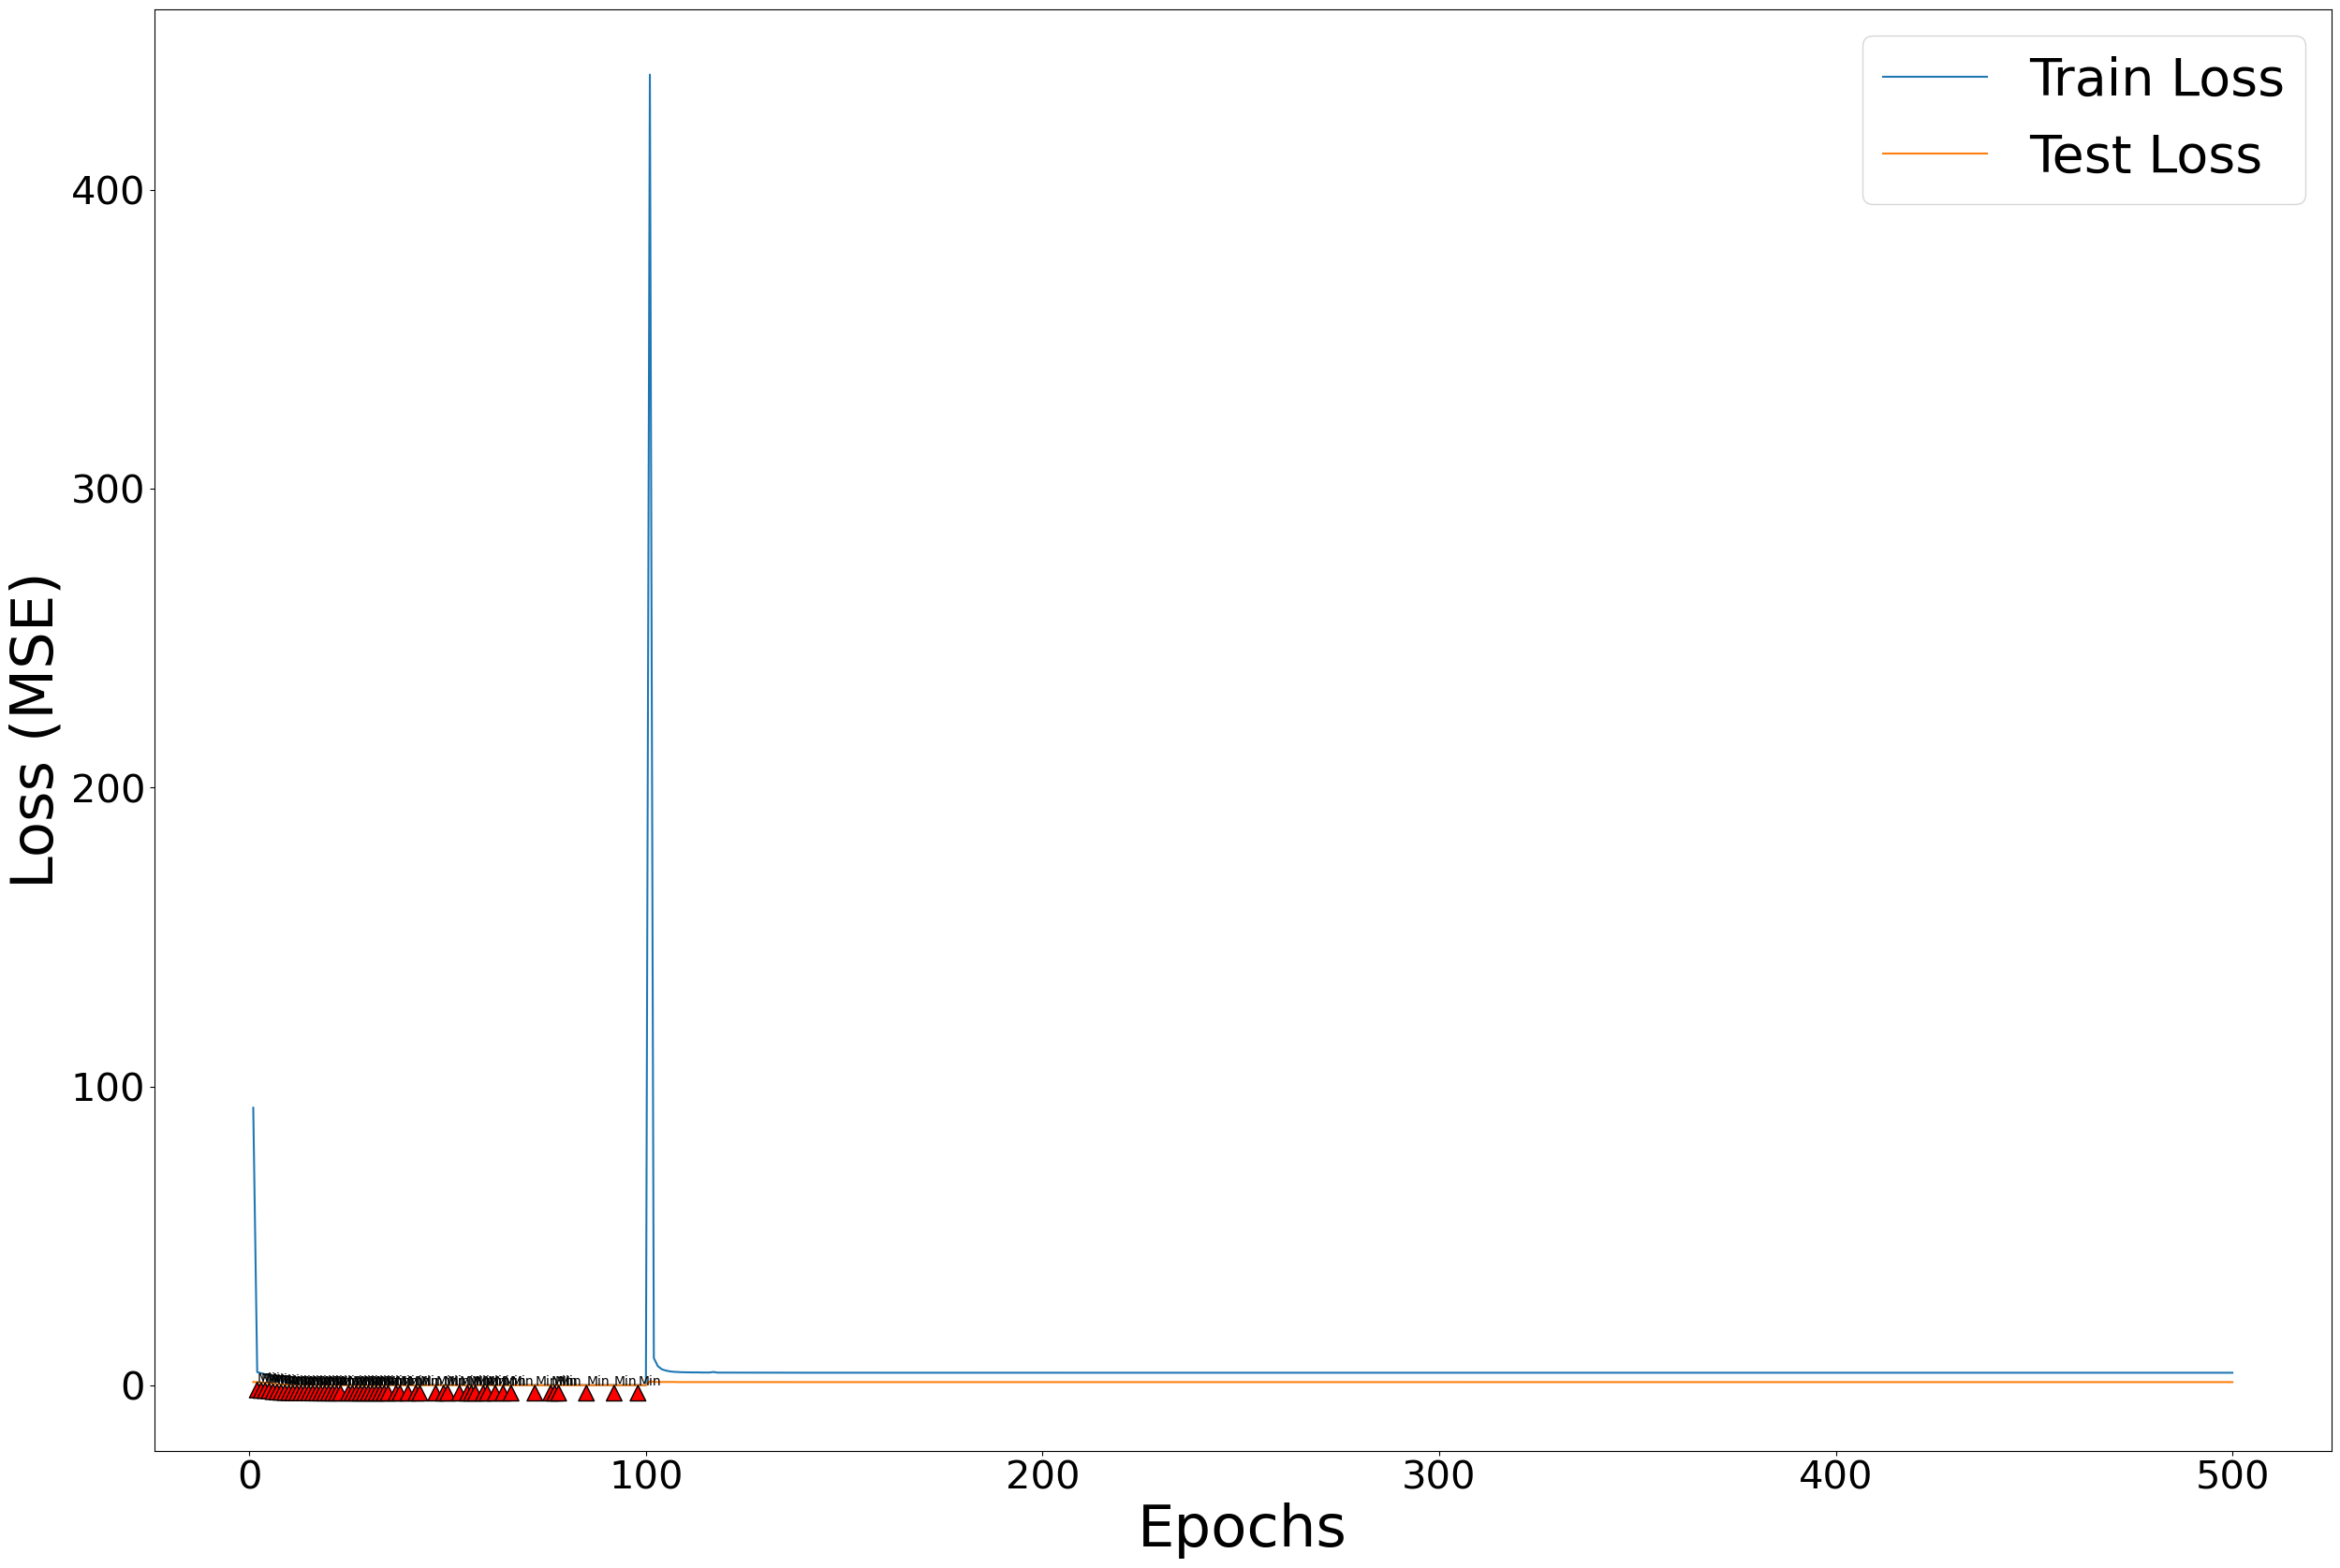

In [15]:

# Plot the data
plt.plot(np.arange(num_epochs)+1, train_losses, label='Train Loss')
plt.plot(np.arange(num_epochs)+1, test_losses, label='Test Loss')

# Track the previous minimum test loss and its index
prev_min_loss = test_losses[0]
prev_min_index = 0

# Annotate each local minimum test loss with arrows
for idx, loss in enumerate(test_losses[1:], start=1):
    if loss < prev_min_loss:
        plt.annotate('Min', xy=(idx+1, loss), xytext=(idx+1, loss),
                     arrowprops=dict(facecolor='red', shrink=0.05))
        prev_min_loss = loss
        prev_min_index = idx
        
# Add x and y labels
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

# Change axis size
plt.rcParams['axes.labelsize'] = 45  # Change label font size

# Change tick size
plt.tick_params(axis='x', labelsize=30)  # Change tick size for x-axis
plt.tick_params(axis='y', labelsize=30)  # Change tick size for y-axis

# Plot legend, and display figure
plt.legend(fontsize = 40)
plt.show()

In [8]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Load the model's state dictionary from the loaded dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model.to(device)

Transformer(
  (embedding): Linear(in_features=1000, out_features=512, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=512, out_features=1000, bias=True)
)

In [9]:
## Switch to directory for saving model metrics

os.chdir('/home/htjhnson/Desktop/DL-NMR-Optimization/ModelPerformanceMetrics') 

In [7]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')


# Load validation dataset
spectraVal400 = np.load('Dataset21_400MHz_AdjustSNR_Val_Spec.npy')
spectraVal100 = np.load('Dataset21_100MHz_AdjustSNR_Val_Spec.npy')


spectraVal100 = torch.tensor(spectraVal100).float().to(device)   # These spectra are the 5000 spectra generated like the training dataset
spectraVal400 = torch.tensor(spectraVal400).float().to(device)


## Create ppm scale for plotting ppm rather than just data point numbers for x-axis
ppm_all = (np.linspace(12.5, -2.5, 65536))
ppm = ppm_all[10000:56000]

In [8]:
## Switch to directory for saving model metrics
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics')

criterion = nn.MSELoss()
model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(spectraVal100[:100])  # Evaluate input spectra 

mse = criterion(outputs, spectraVal400[:100])


# Print MSE
print('model err: ', mse)  # Print MSE

# Save RMSE to a file
np.save(ModelName + "ValMSE.npy", mse.cpu().detach().numpy())

model err:  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


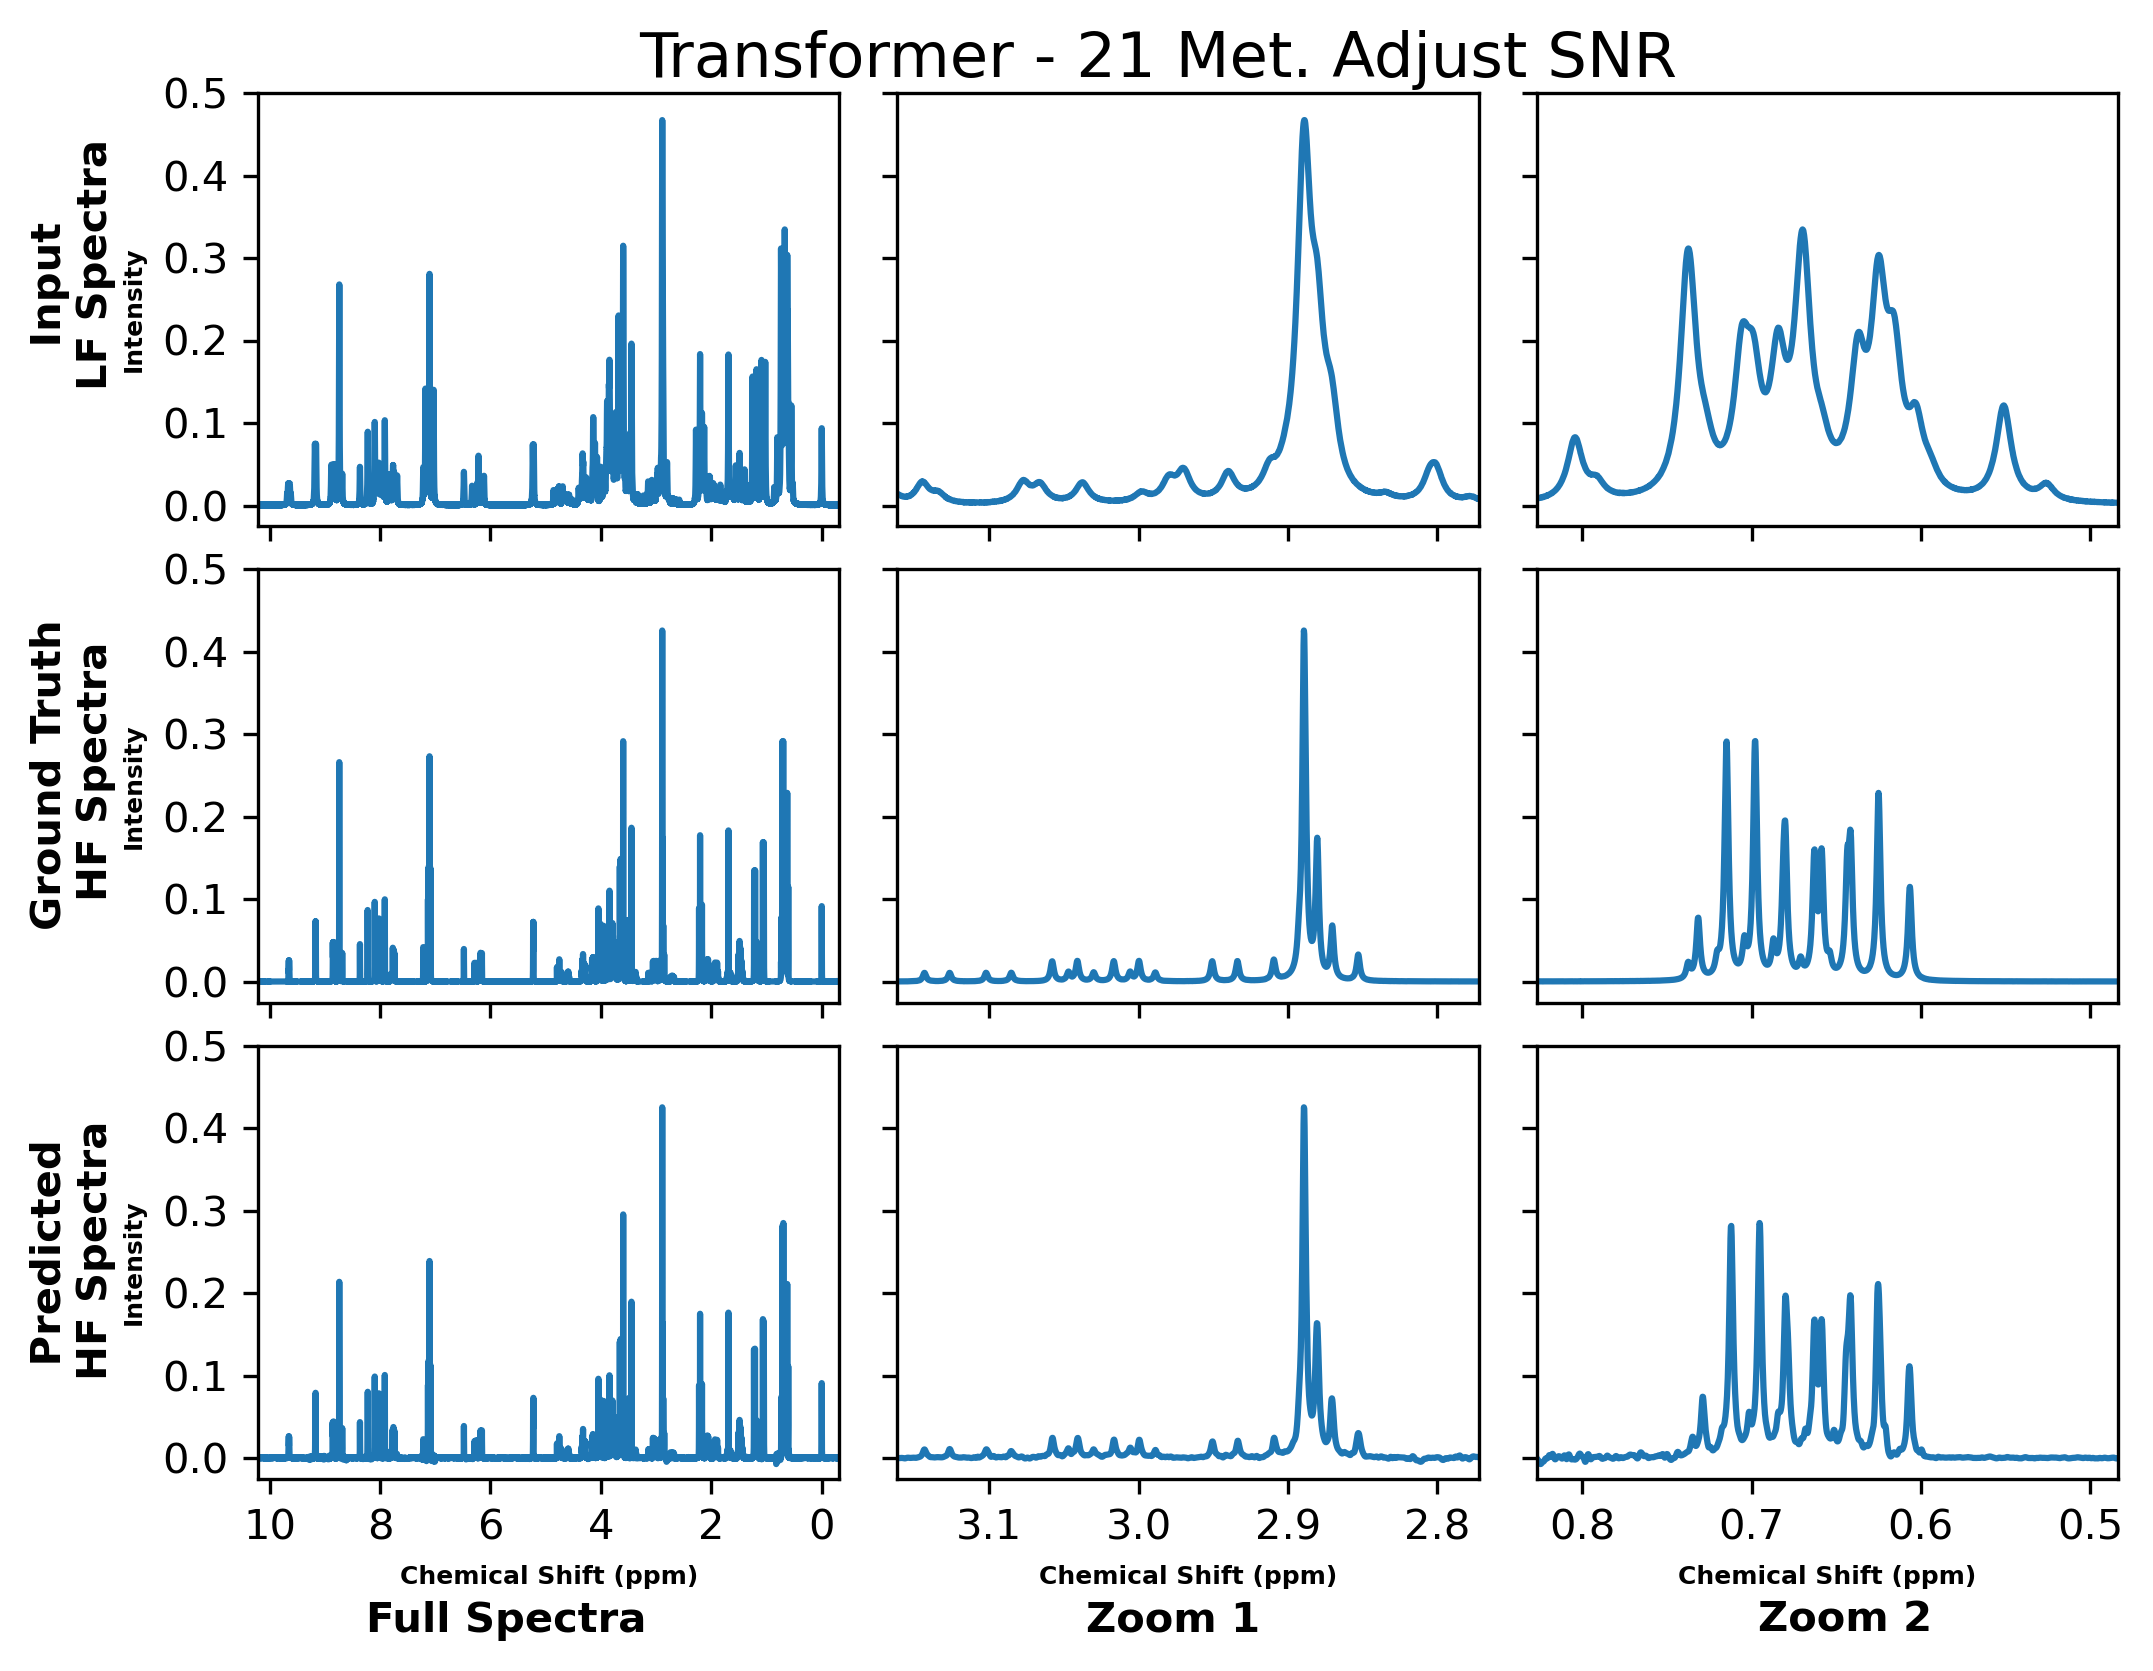

In [10]:
# Get predicted data from the model
Predicted = model(spectraVal100[0].unsqueeze(0)).cpu().detach().numpy()[0]

# Create figure and subplots with adjusted spacing
fig, axs = plt.subplots(3, 3, figsize=(8, 6), dpi=300)
fig.subplots_adjust(hspace=0.1, wspace=0.1)  # Adjust vertical and horizontal space

# Plotting data for each subplot
axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[0], ppm[-1])
axs[0, 0].set_ylim(-0.025, 0.5)
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[30800], ppm[32500])
axs[0, 1].set_ylim(-0.025, 0.5)
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[41000], ppm[42500])
axs[0, 2].set_ylim(-0.025, 0.5)

axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[0], ppm[-1])
axs[1, 0].set_ylim(-0.025, 0.5)
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[30800], ppm[32500])
axs[1, 1].set_ylim(-0.025, 0.5)
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[41000], ppm[42500])
axs[1, 2].set_ylim(-0.025, 0.5)

axs[2, 0].plot(ppm, Predicted)
axs[2, 0].set_xlim(ppm[0], ppm[-1])
axs[2, 0].set_ylim(-0.025, 0.5)
axs[2, 1].plot(ppm, Predicted)
axs[2, 1].set_xlim(ppm[30800], ppm[32500])
axs[2, 1].set_ylim(-0.025, 0.5)
axs[2, 2].plot(ppm, Predicted)
axs[2, 2].set_xlim(ppm[41000], ppm[42500])
axs[2, 2].set_ylim(-0.025, 0.5)


# Add main titles inside each subplot
count = -1
plt.rcParams.update({'font.size': 7})
xlabels = ["Chemical Shift (ppm)", "Chemical Shift (ppm)", "Chemical Shift (ppm)"] * 3
ylabels = ["Intensity", "Intensity", "Intensity"] * 3

for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count], fontweight='bold', fontsize=6)
    ax.set_ylabel(ylabels[count], fontweight='bold', fontsize=6)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

    # Add an overall title at the top
fig.suptitle('Transformer - 21 Met. Adjust SNR', fontsize=15, x=0.5, y=0.915)

# Add subtitles as the main titles for each row and column
fig.text(0.03, 0.72, "   Input \nLF Spectra", rotation='vertical', fontweight='bold', fontsize=10)
fig.text(0.03, 0.42, "Ground Truth \n  HF Spectra", rotation='vertical', fontweight='bold', fontsize=10)
fig.text(0.03, 0.17, " Predicted \nHF Spectra", rotation='vertical', fontweight='bold', fontsize=10)

fig.text(0.17, 0.02, "Full Spectra", va='bottom', fontweight='bold', fontsize=10)
fig.text(0.47, 0.02, "Zoom 1", va='bottom', fontweight='bold', fontsize=10)
fig.text(0.75, 0.02, "Zoom 2", va='bottom', fontweight='bold', fontsize=10)

plt.savefig('Transformer_21_AdjustSNR_Visual.png', dpi=600, bbox_inches='tight')

plt.show()

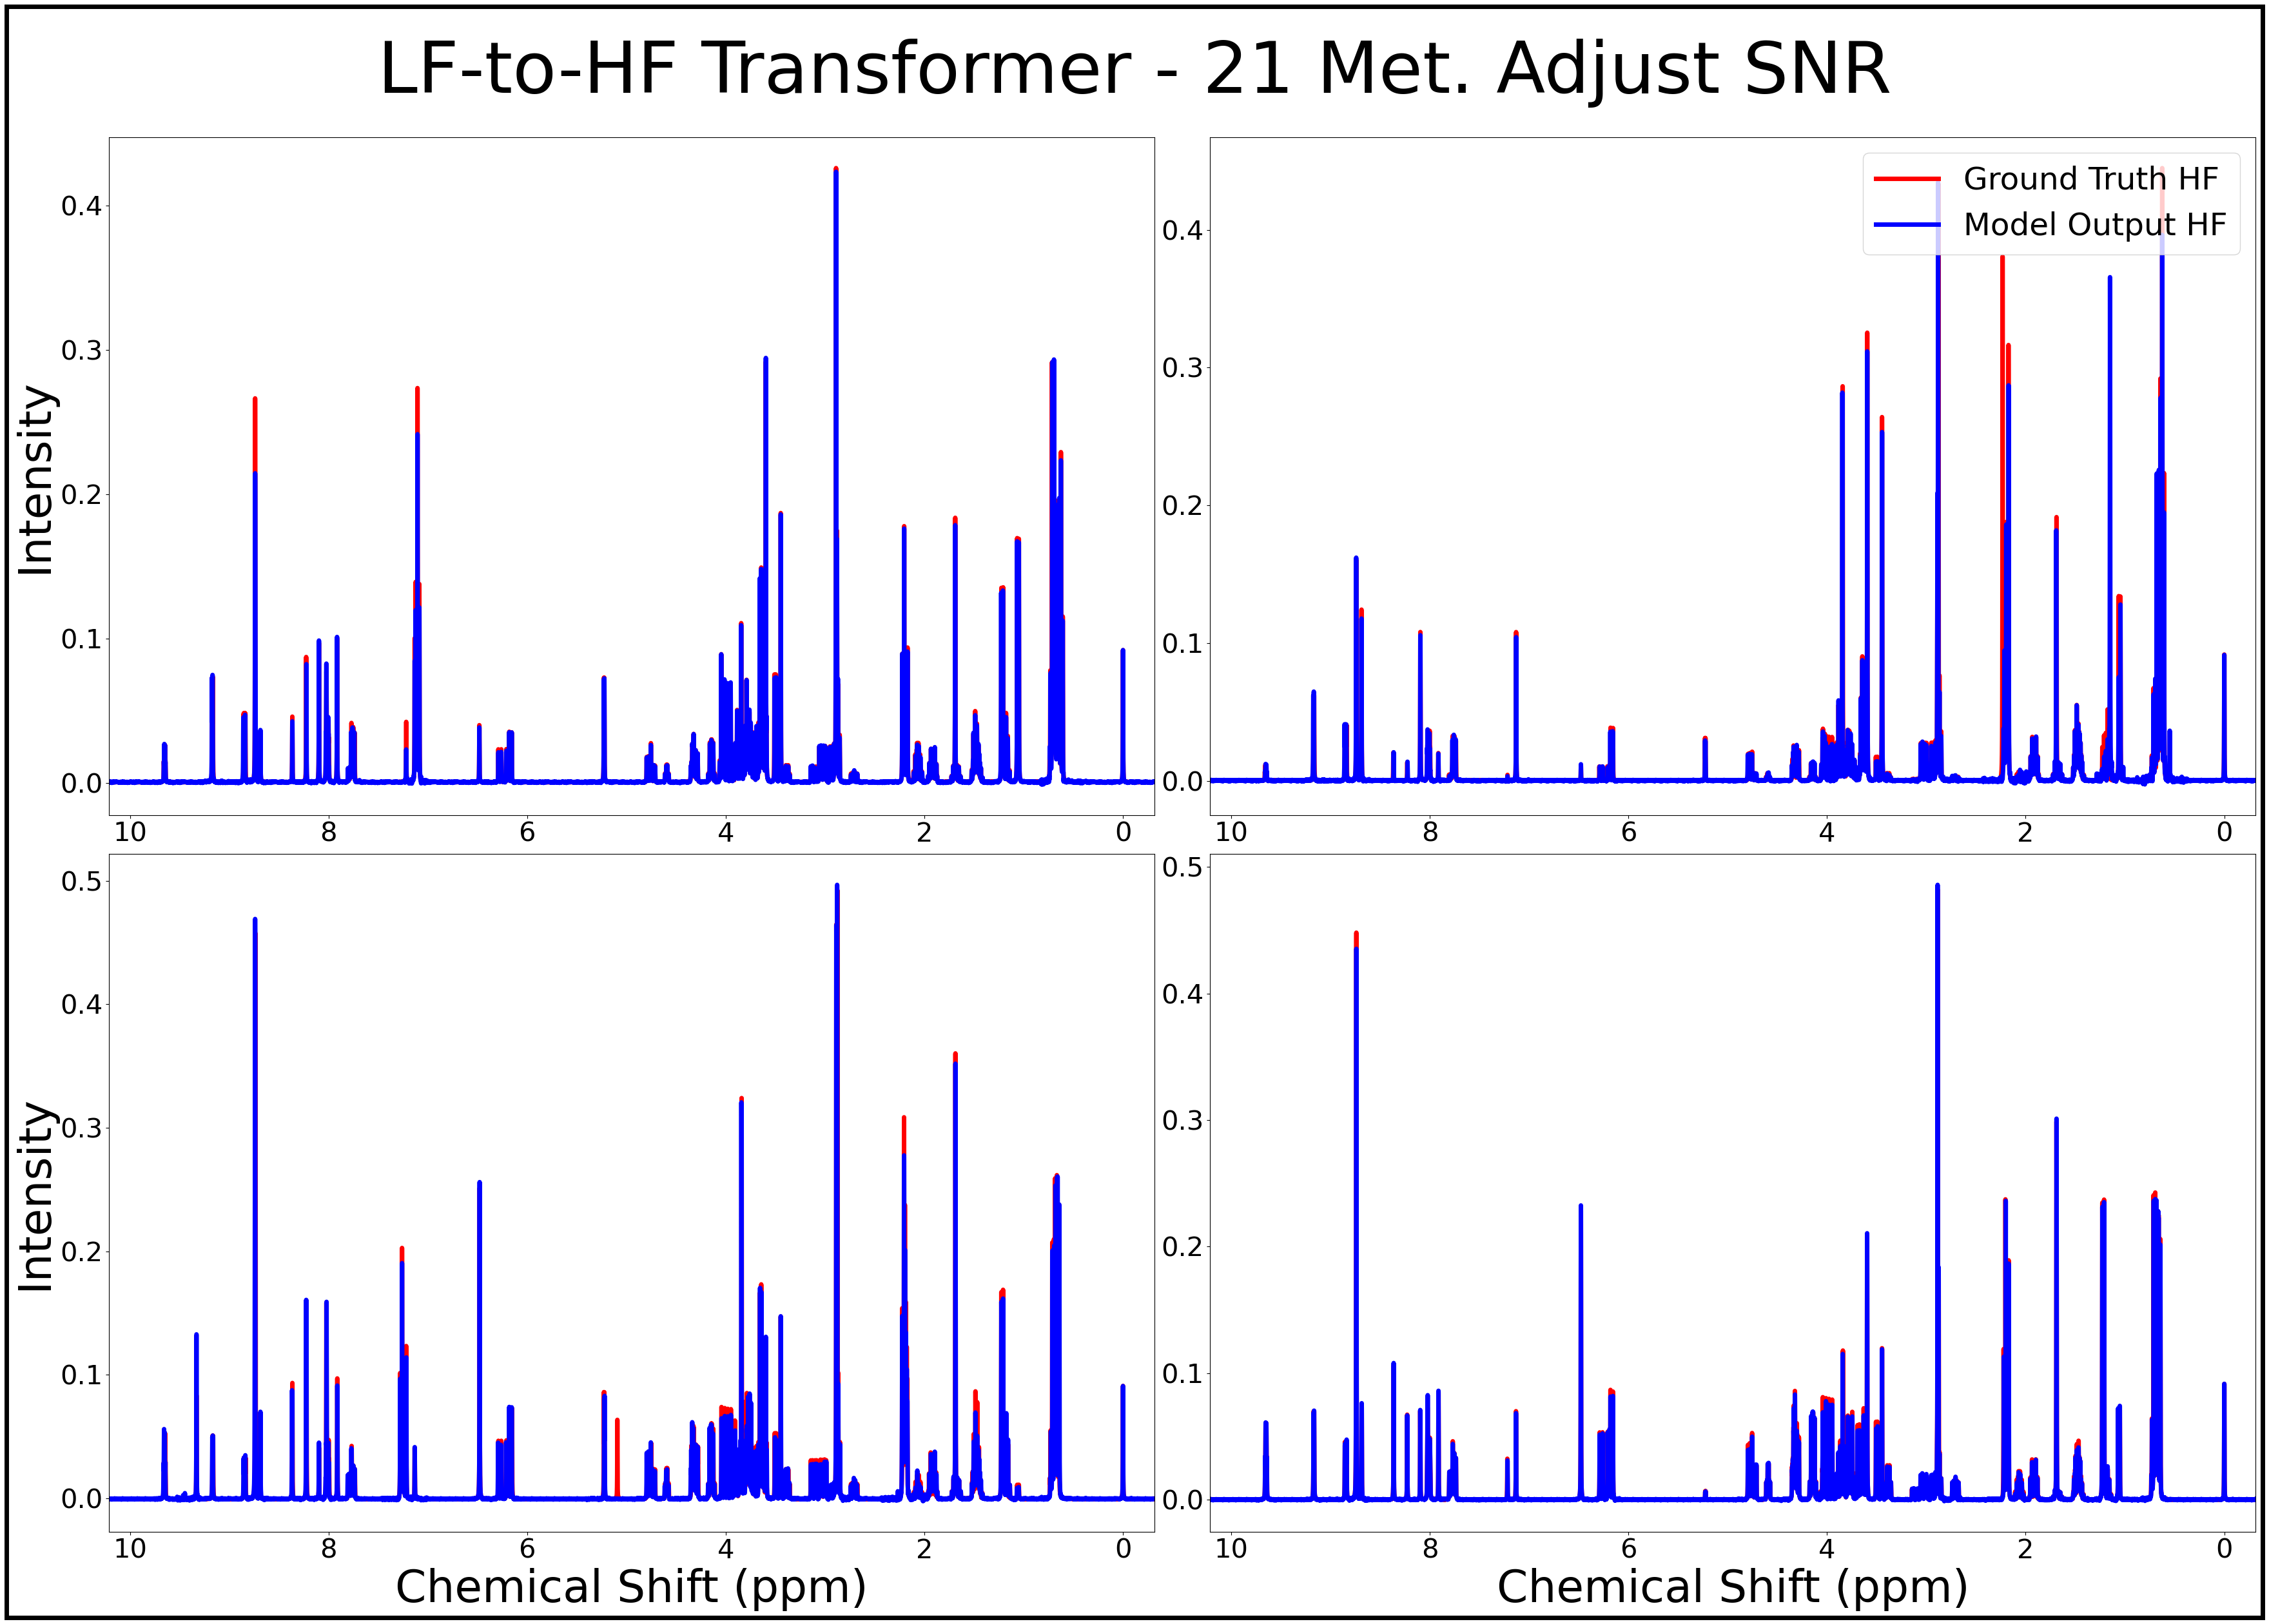

In [12]:
os.chdir('/home/htjhnson/Desktop/LF_to_HF/Figures')


LF = spectraVal100[:100]
GT = spectraVal400[:100]
criterion = nn.MSELoss()



# Create a figure with 2 columns and 2 rows
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(35, 25))

# Flatten the axes array for easy iteration
axes = axes.flatten()

model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(LF).cpu().detach().numpy()

for i in range(4):
    ax = axes[i]
    ax.plot(ppm, GT[i].cpu().detach().numpy(), color='red', linewidth=5, label='Ground Truth HF')
    ax.plot(ppm, outputs[i], color='blue', linewidth=5, label='Model Output HF')
    ax.set_xlim(ppm[0], ppm[-1])

    
    
    # Add legend to the top-right plot (i == 1)
    if i == 1:
        ax.legend(loc='upper right', fontsize = 35)

    # Set x and y labels for the bottom two plots and left five plots
    if i // 2 == 1:  # Bottom two plots (8, 9)
        ax.set_xlabel('Chemical Shift (ppm)', fontsize=50)
    if i % 2 == 0:  # Left five plots (0, 2, 4, 6, 8)
        ax.set_ylabel('Intensity', fontsize=50)
        
    # Modify the size of the tick marks and numbers
    ax.tick_params(axis='both', which='major', labelsize=30)  # major ticks
    ax.tick_params(axis='both', which='minor', labelsize=30)  # minor ticks

# Add an overall title at the top
fig.suptitle('LF-to-HF Transformer - 21 Met. Adjust SNR', fontsize=80)

# Add a rectangle around the entire figure
rect = plt.Rectangle((0, 0), 1, 1, transform=fig.transFigure, linewidth=5, edgecolor='black', facecolor='none')
fig.patches.append(rect)



plt.tight_layout(rect=[0, 0, 1, 0.97])
# Save the figure as a PNG with high resolution
plt.savefig('LF-to-HF_Transformer-21MetAdjustSNR.png', dpi=600, bbox_inches='tight')

plt.show()

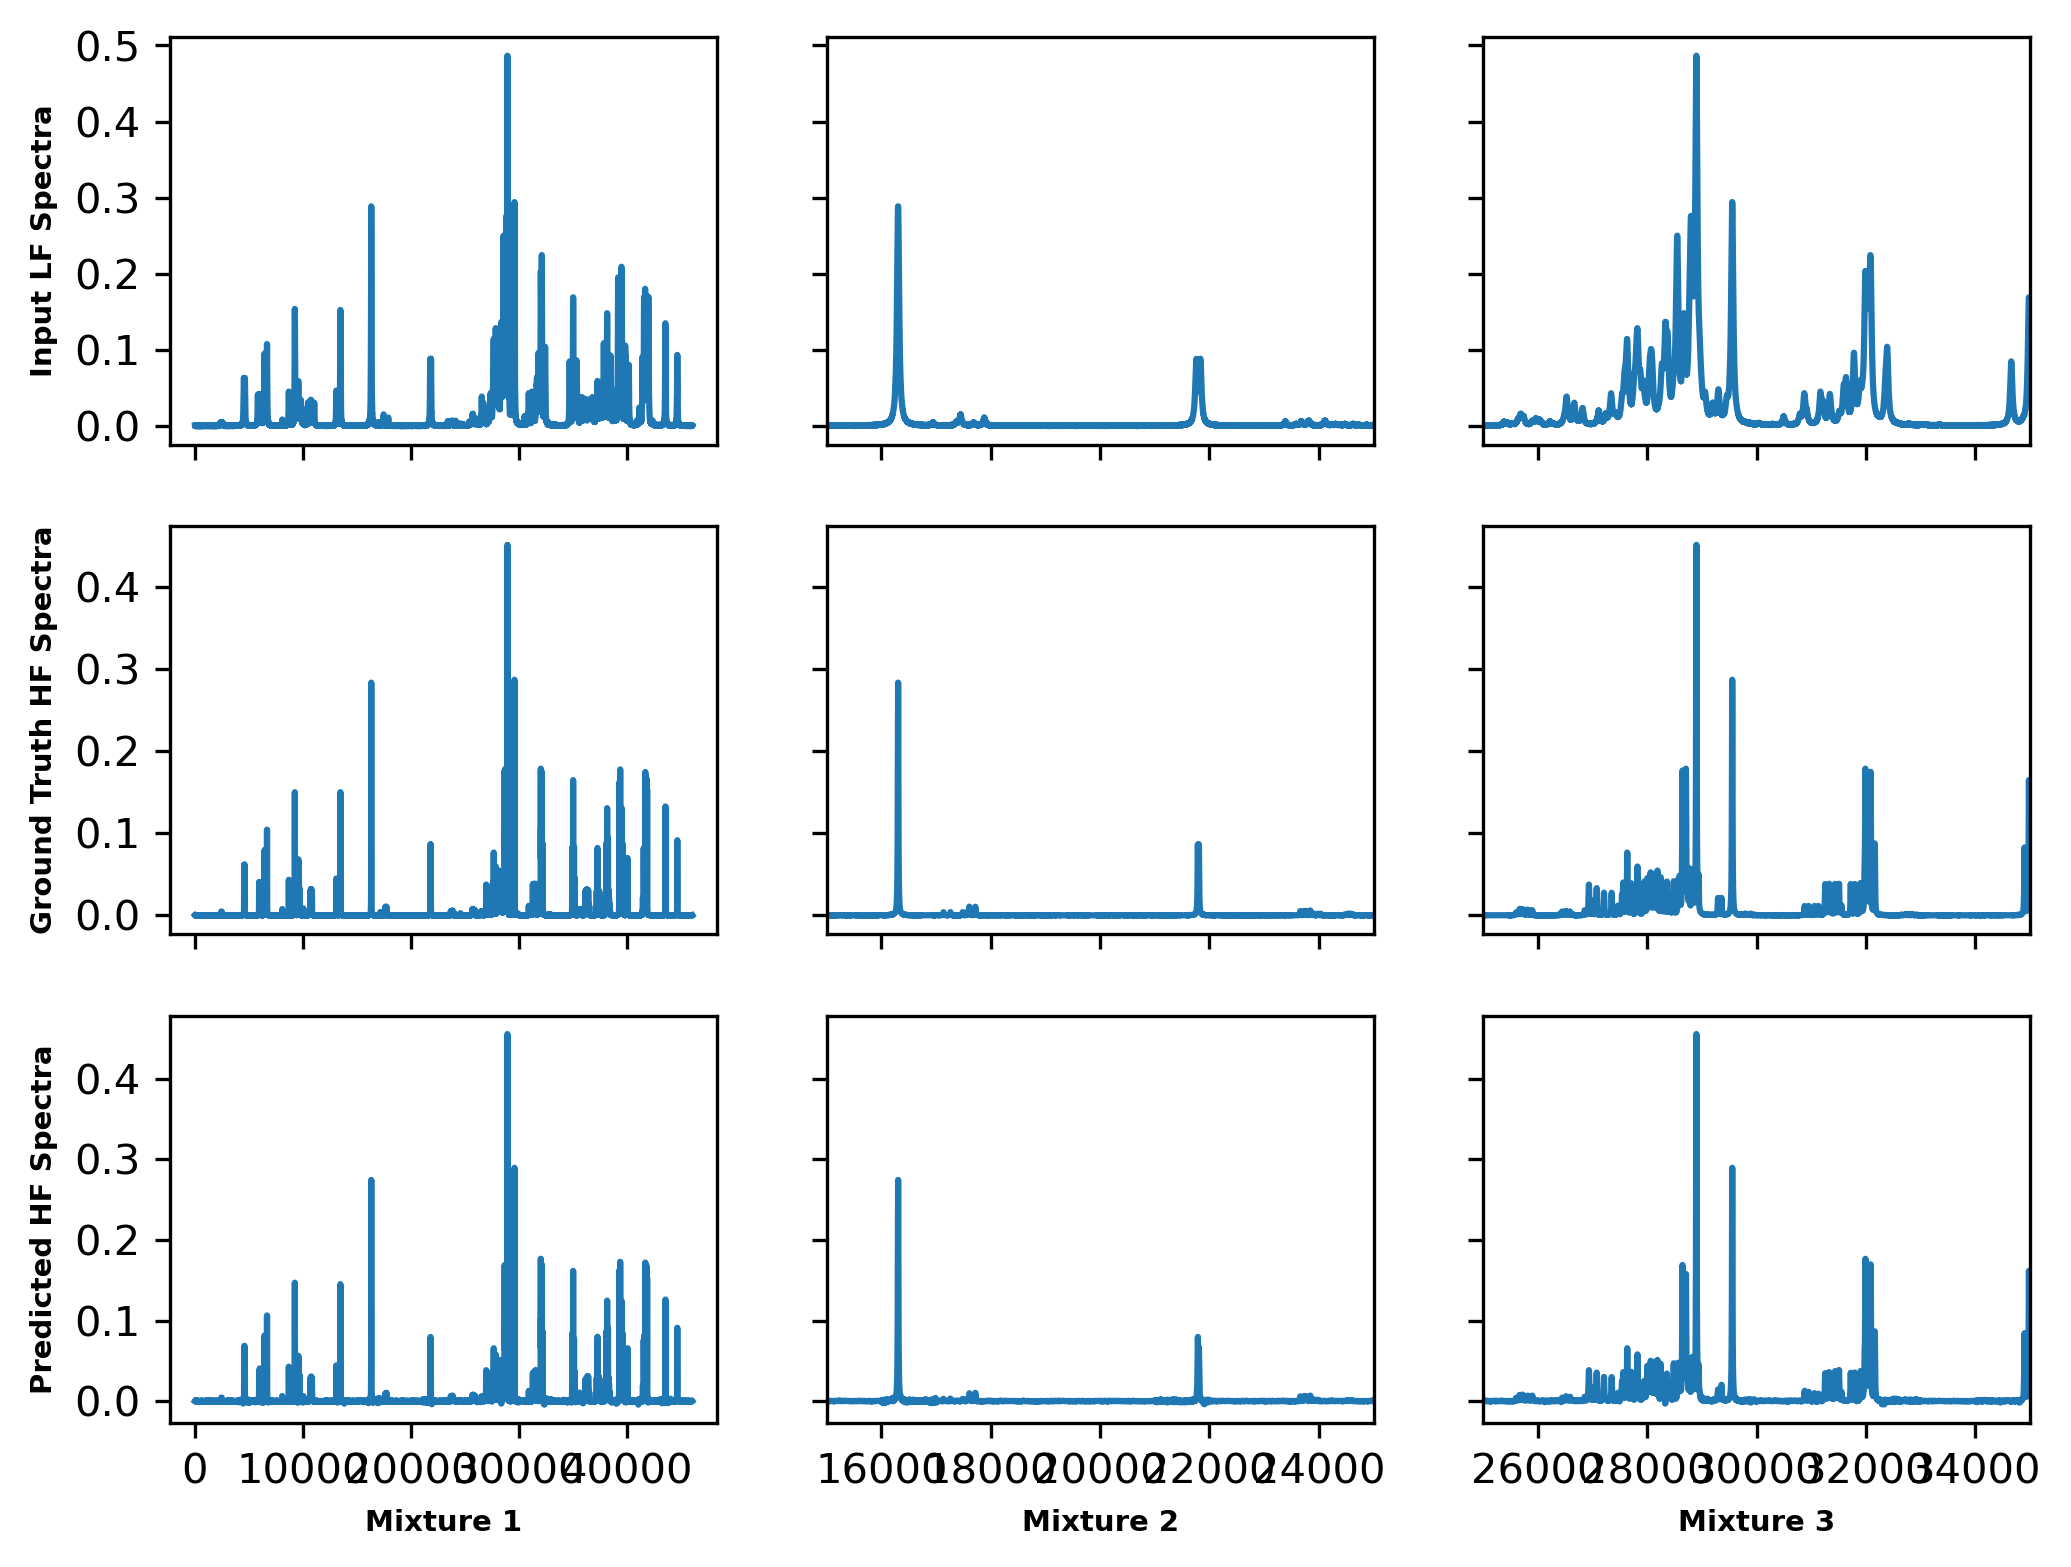

In [11]:
Predicted = model(X_train[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(X_train[0].cpu().detach().numpy())
#axs[0, 0].set_xlim([15000,25000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(X_train[0].cpu().detach().numpy())
axs[0, 1].set_xlim([15000,25000])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(X_train[0].cpu().detach().numpy())
axs[0, 2].set_xlim([25000,35000])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(y_train[0].cpu().detach().numpy())
#axs[1, 0].set_xlim([15000,25000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(y_train[0].cpu().detach().numpy())
axs[1, 1].set_xlim([15000,25000])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(y_train[0].cpu().detach().numpy())
axs[1, 2].set_xlim([25000,35000])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
#axs[2, 0].set_xlim([15000,25000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([15000,25000])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([25000,35000])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')

count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

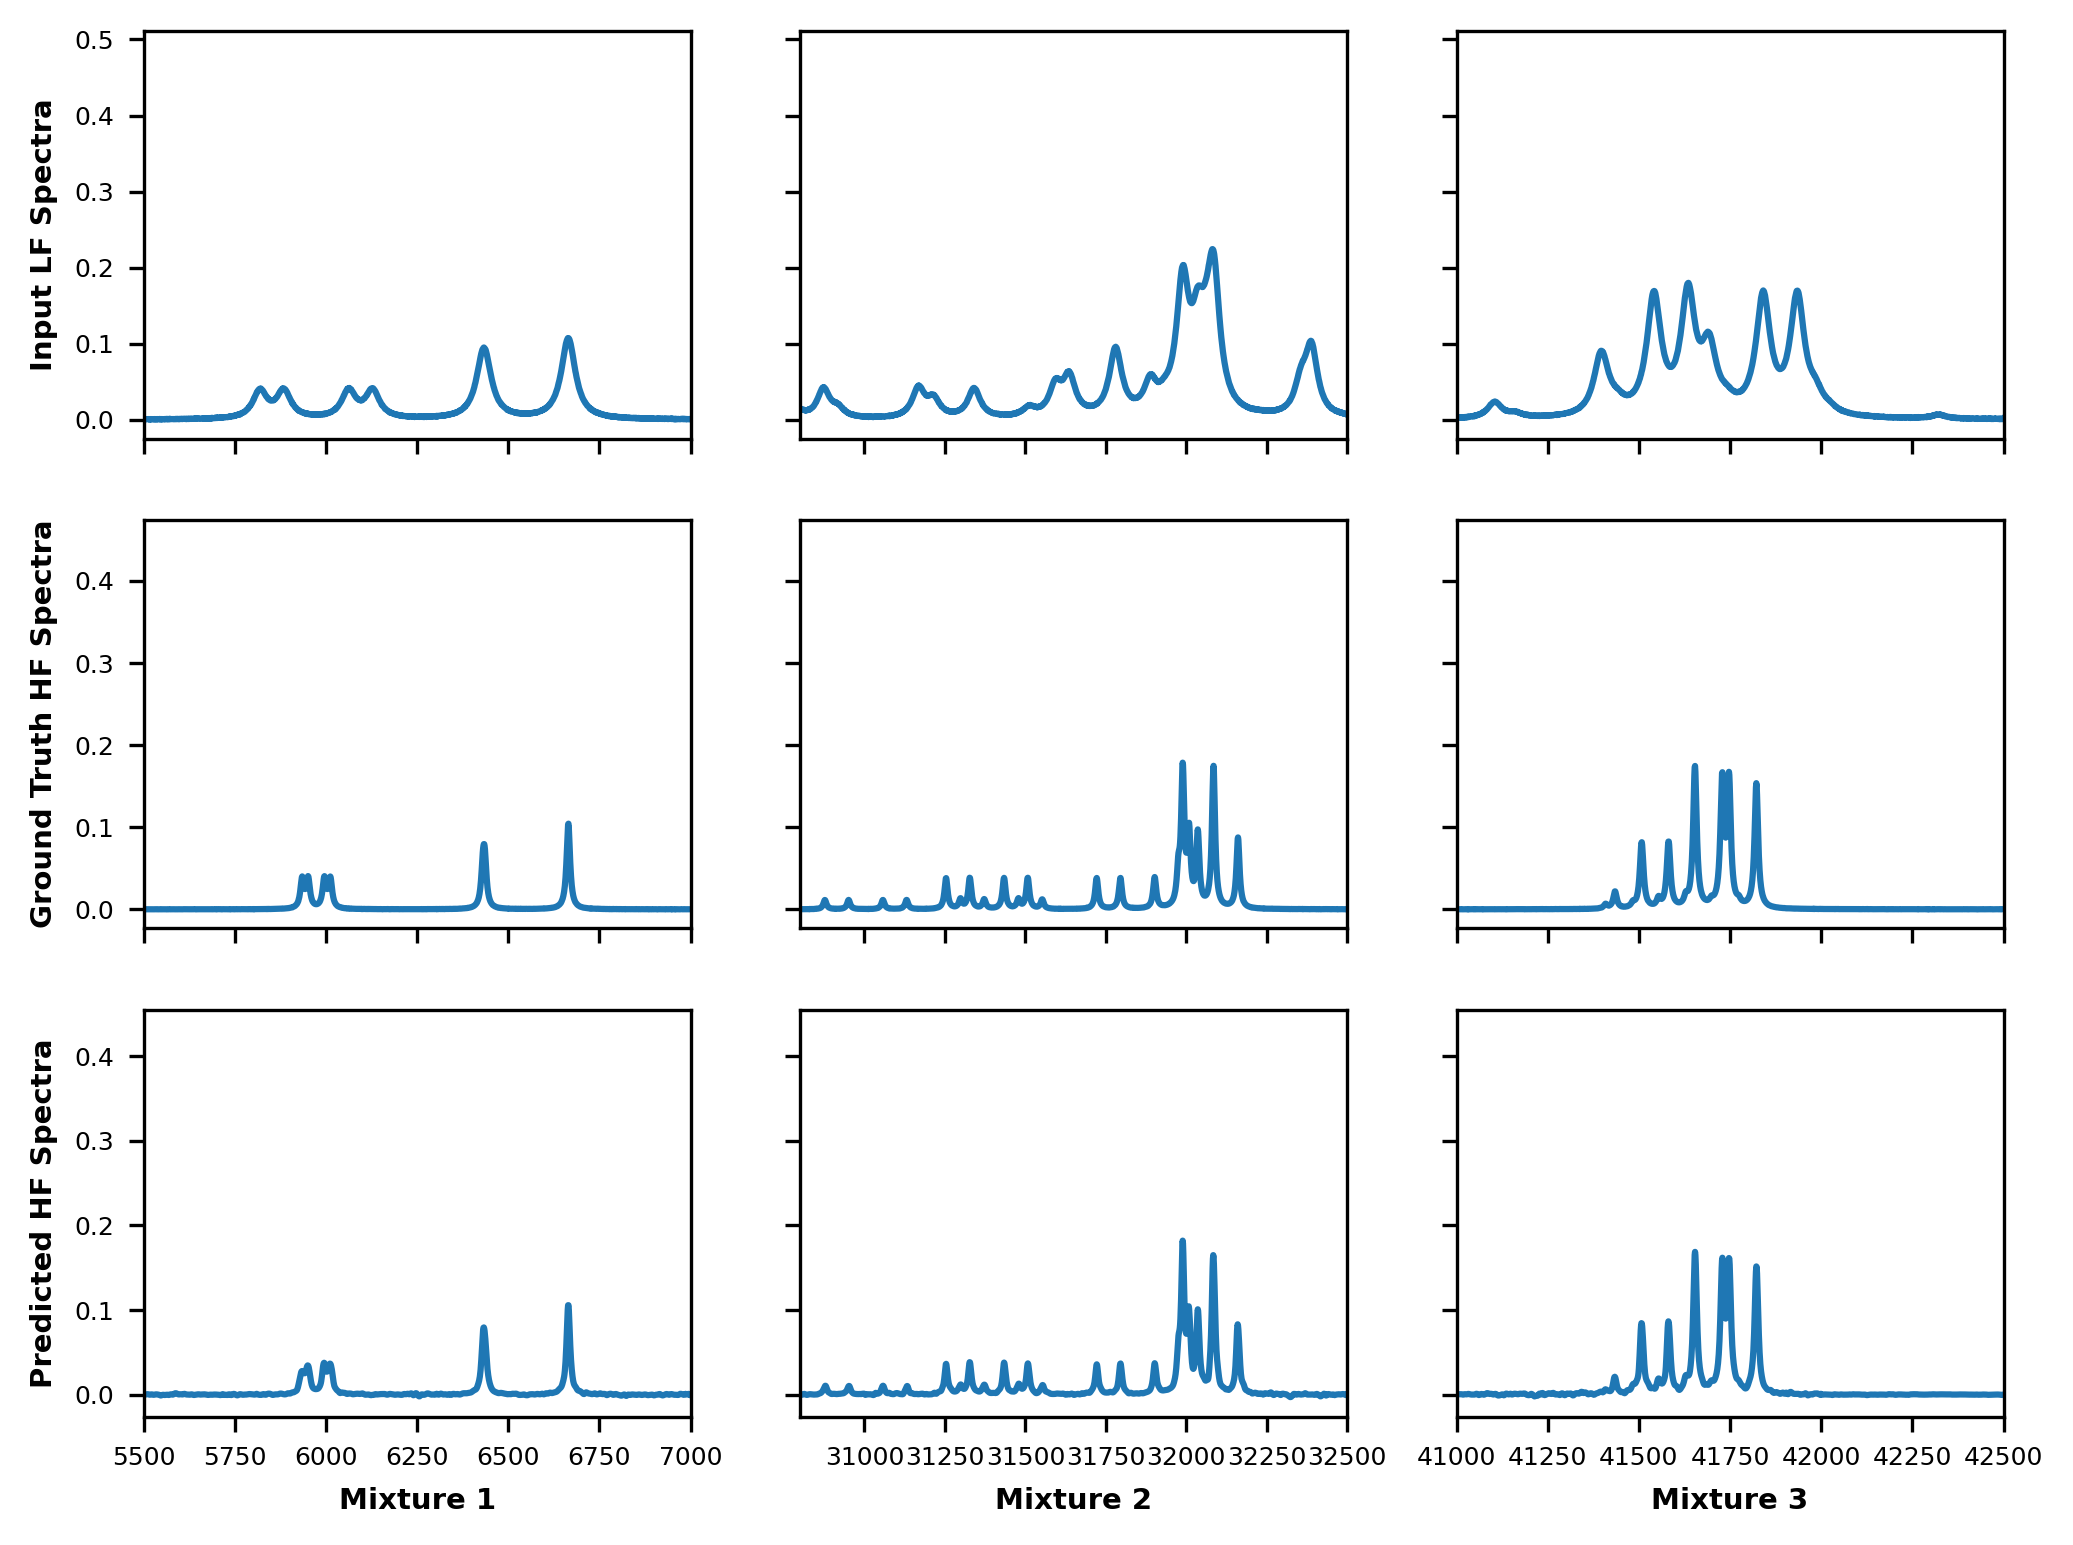

In [12]:
Predicted = model(X_train[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(X_train[0].cpu().detach().numpy())
axs[0, 0].set_xlim([5500,7000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(X_train[0].cpu().detach().numpy())
axs[0, 1].set_xlim([30800,32500])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(X_train[0].cpu().detach().numpy())
axs[0, 2].set_xlim([41000,42500])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(y_train[0].cpu().detach().numpy())
axs[1, 0].set_xlim([5500,7000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(y_train[0].cpu().detach().numpy())
axs[1, 1].set_xlim([30800,32500])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(y_train[0].cpu().detach().numpy())
axs[1, 2].set_xlim([41000,42500])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
axs[2, 0].set_xlim([5500,7000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([30800,32500])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([41000,42500])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

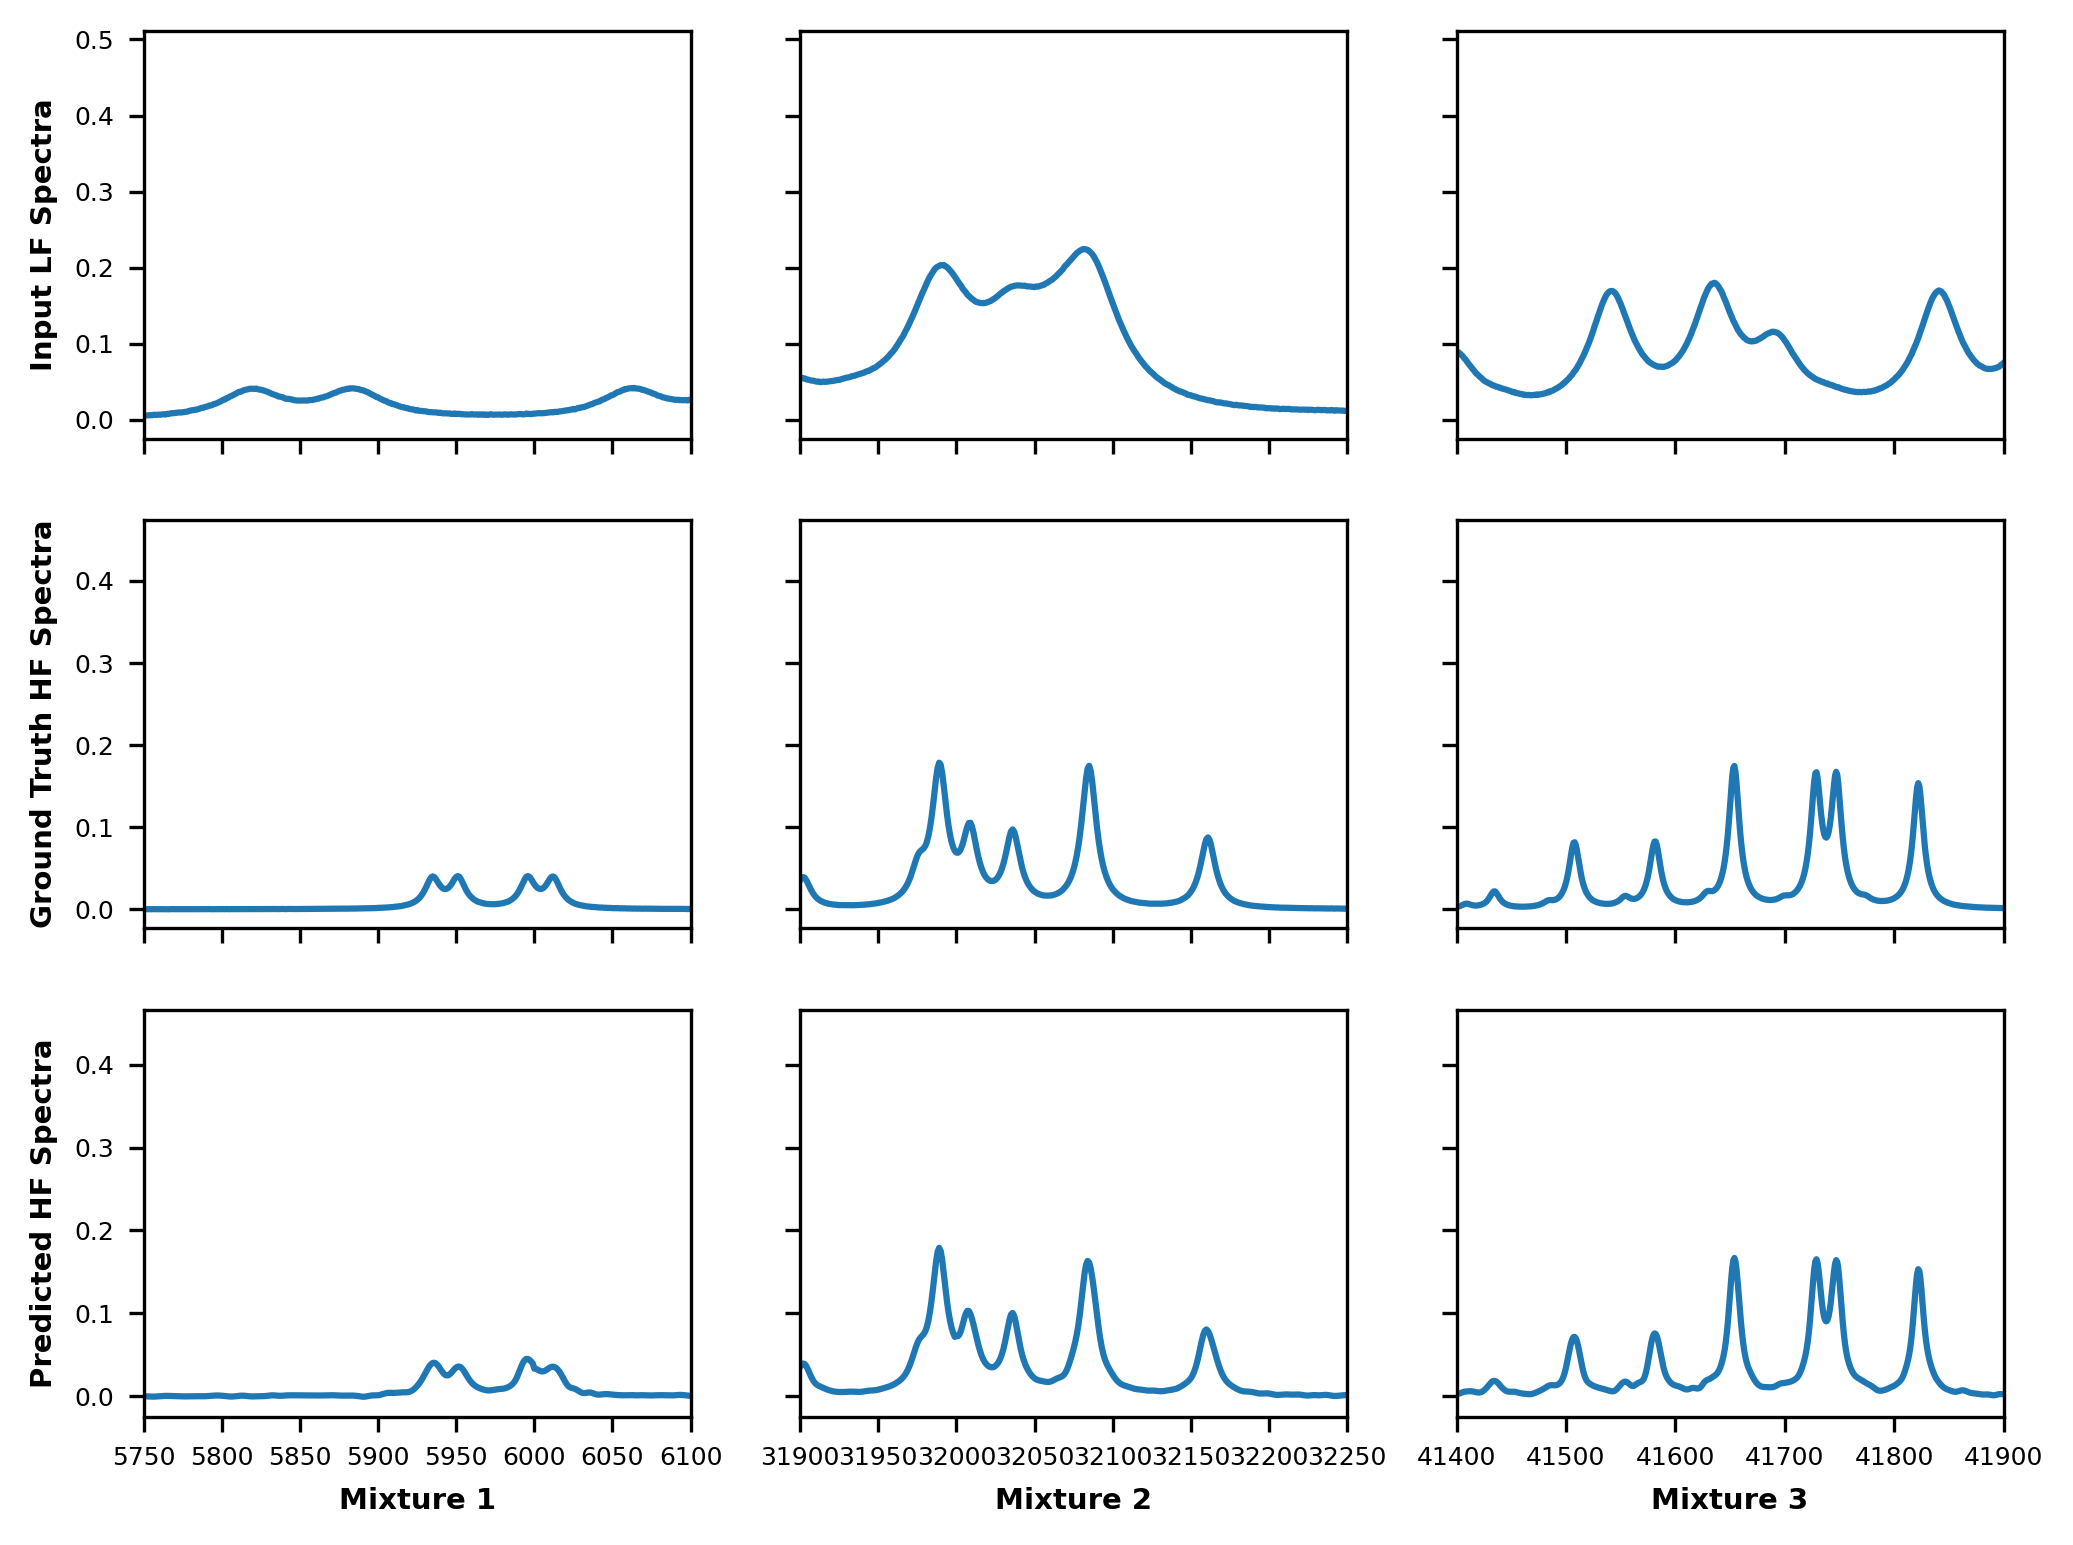

In [13]:
Predicted = model(X_train[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(X_train[0].cpu().detach().numpy())
axs[0, 0].set_xlim([5750,6100])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(X_train[0].cpu().detach().numpy())
axs[0, 1].set_xlim([31900,32250])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(X_train[0].cpu().detach().numpy())
axs[0, 2].set_xlim([41400,41900])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(y_train[0].cpu().detach().numpy())
axs[1, 0].set_xlim([5750,6100])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(y_train[0].cpu().detach().numpy())
axs[1, 1].set_xlim([31900,32250])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(y_train[0].cpu().detach().numpy())
axs[1, 2].set_xlim([41400,41900])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
axs[2, 0].set_xlim([5750,6100])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([31900,32250])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([41400,41900])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

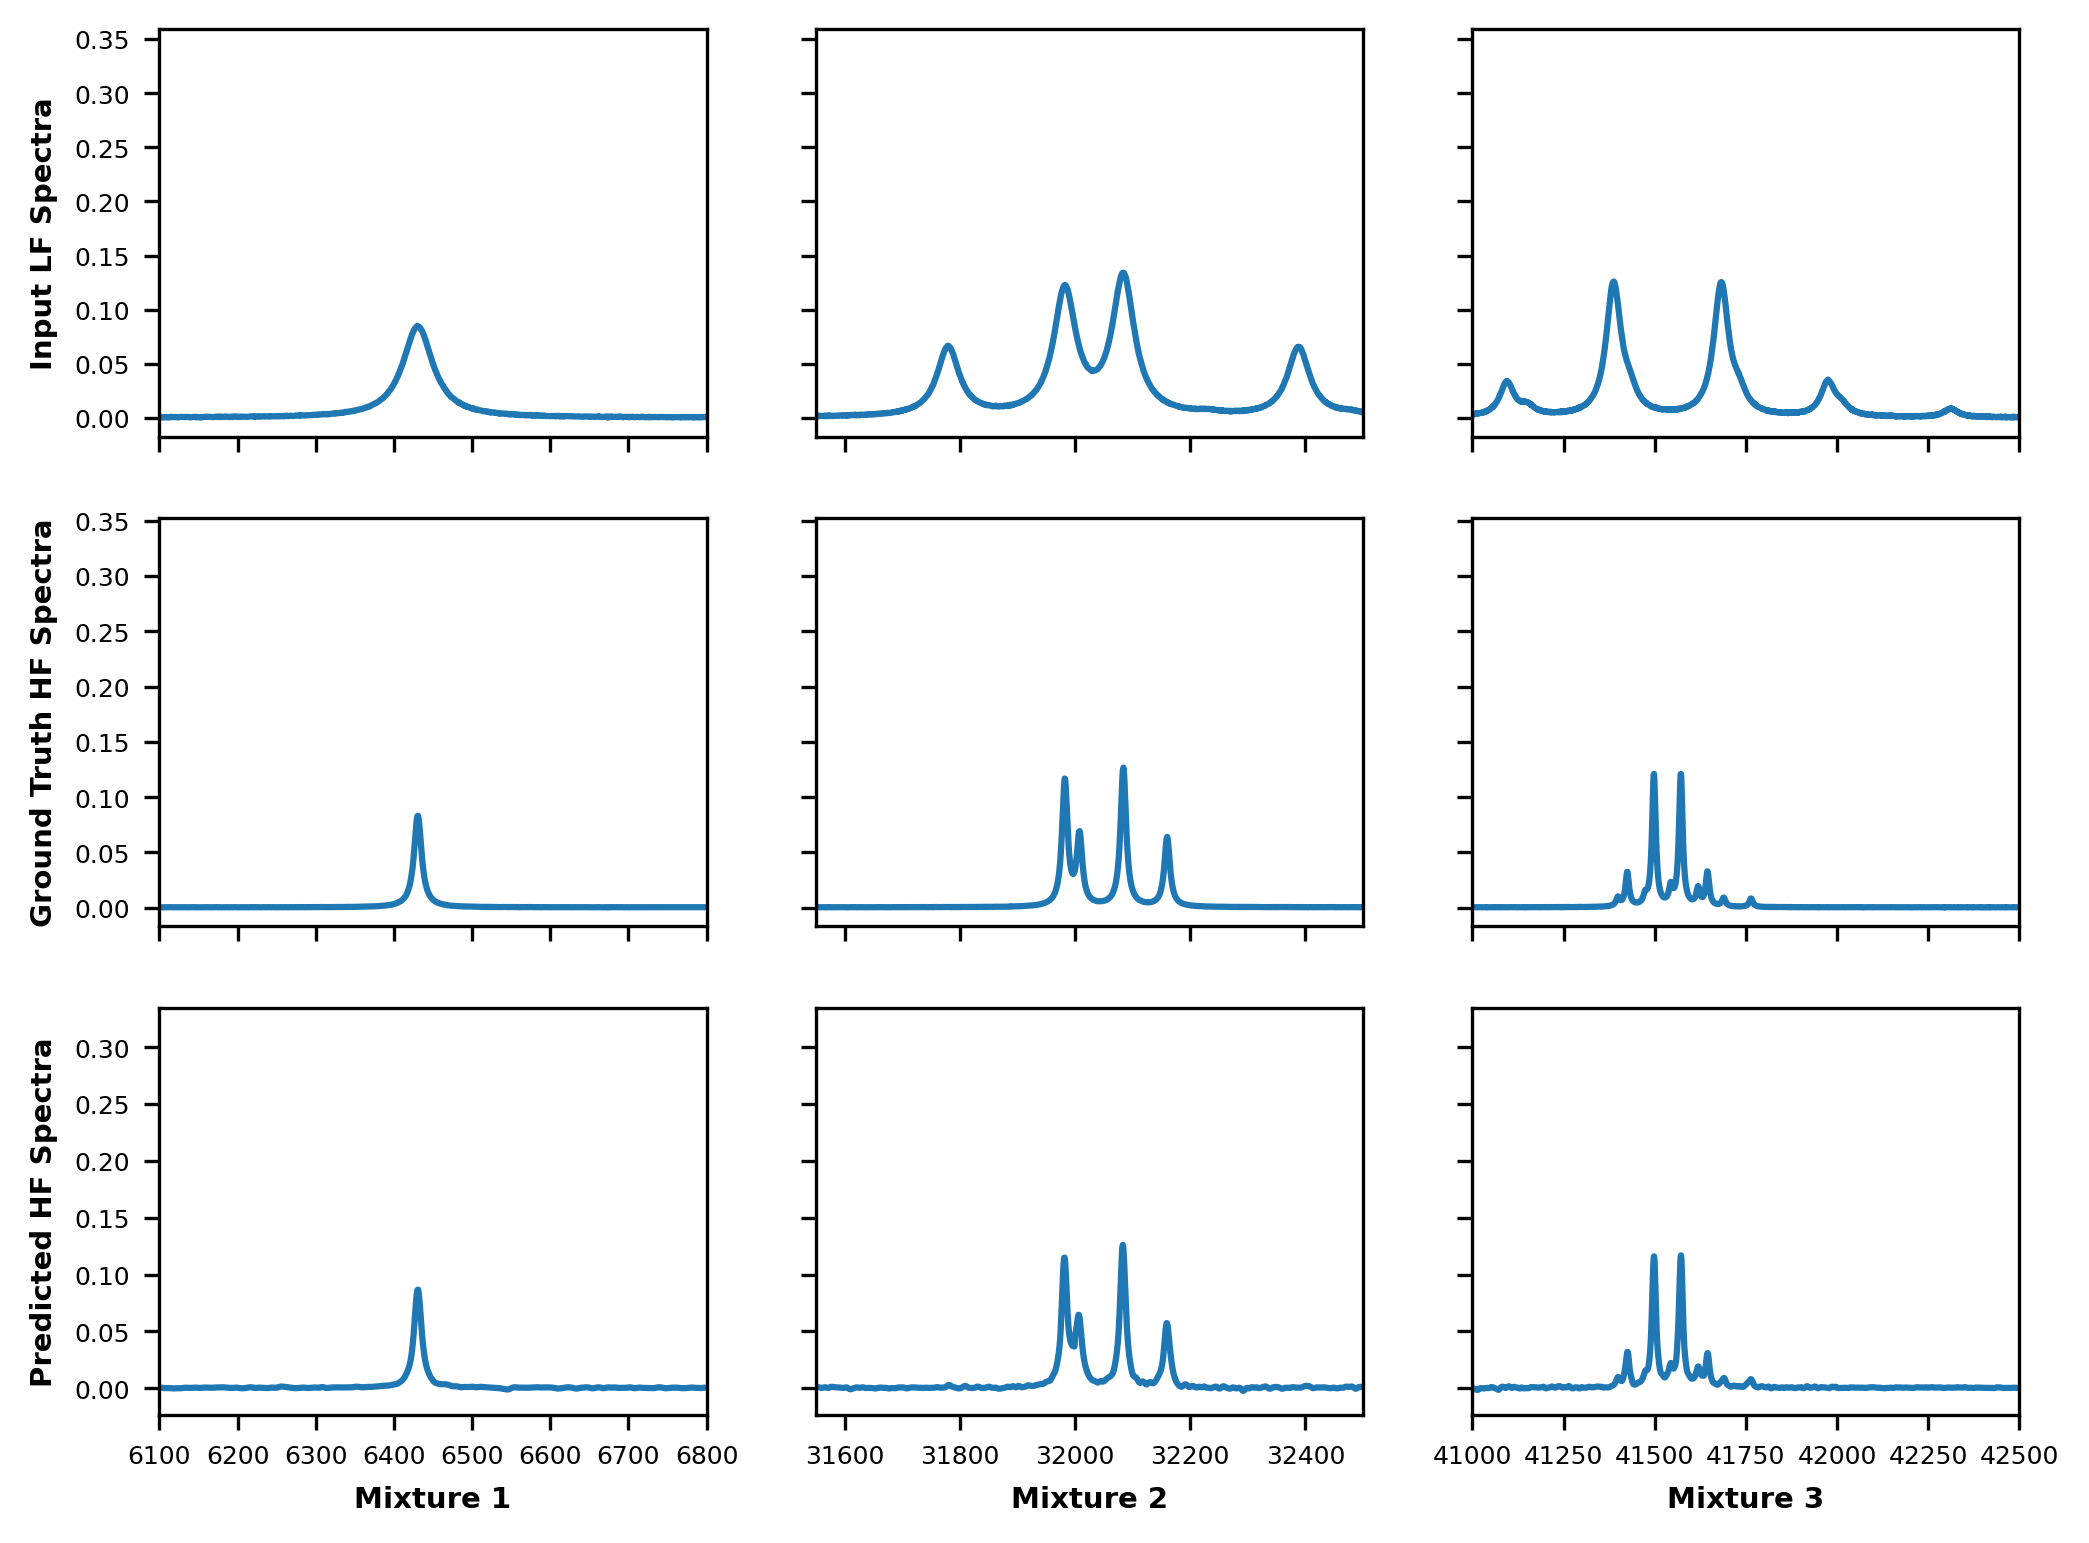

In [14]:
Predicted = model(X_test[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(X_test[0].cpu().detach().numpy())
axs[0, 0].set_xlim([6100,6800])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(X_test[0].cpu().detach().numpy())
axs[0, 1].set_xlim([31550,32500])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(X_test[0].cpu().detach().numpy())
axs[0, 2].set_xlim([41000,42500])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(y_test[0].cpu().detach().numpy())
axs[1, 0].set_xlim([6100,6800])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(y_test[0].cpu().detach().numpy())
axs[1, 1].set_xlim([31550,32500])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(y_test[0].cpu().detach().numpy())
axs[1, 2].set_xlim([41000,42500])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
axs[2, 0].set_xlim([6100,6800])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([31550,32500])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([41000,42500])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

## Test on 12 metabolites not seen in training

In [2]:
# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra400_12NewMet = np.load('Dataset21_Other12Met_400MHz_Val_Spec.npy')
spectra100_12NewMet = np.load('Dataset21_Other12Met_100MHz_Val_Spec.npy')
conc_12NewMet = np.load('Dataset21_Other12Met_Val_Conc.npy')

# Prepare for input into model
spectra400_12NewMet = torch.tensor(spectra400_12NewMet).float().to(device)
spectra100_12NewMet = torch.tensor(spectra100_12NewMet).float().to(device)

NameError: name 'device' is not defined

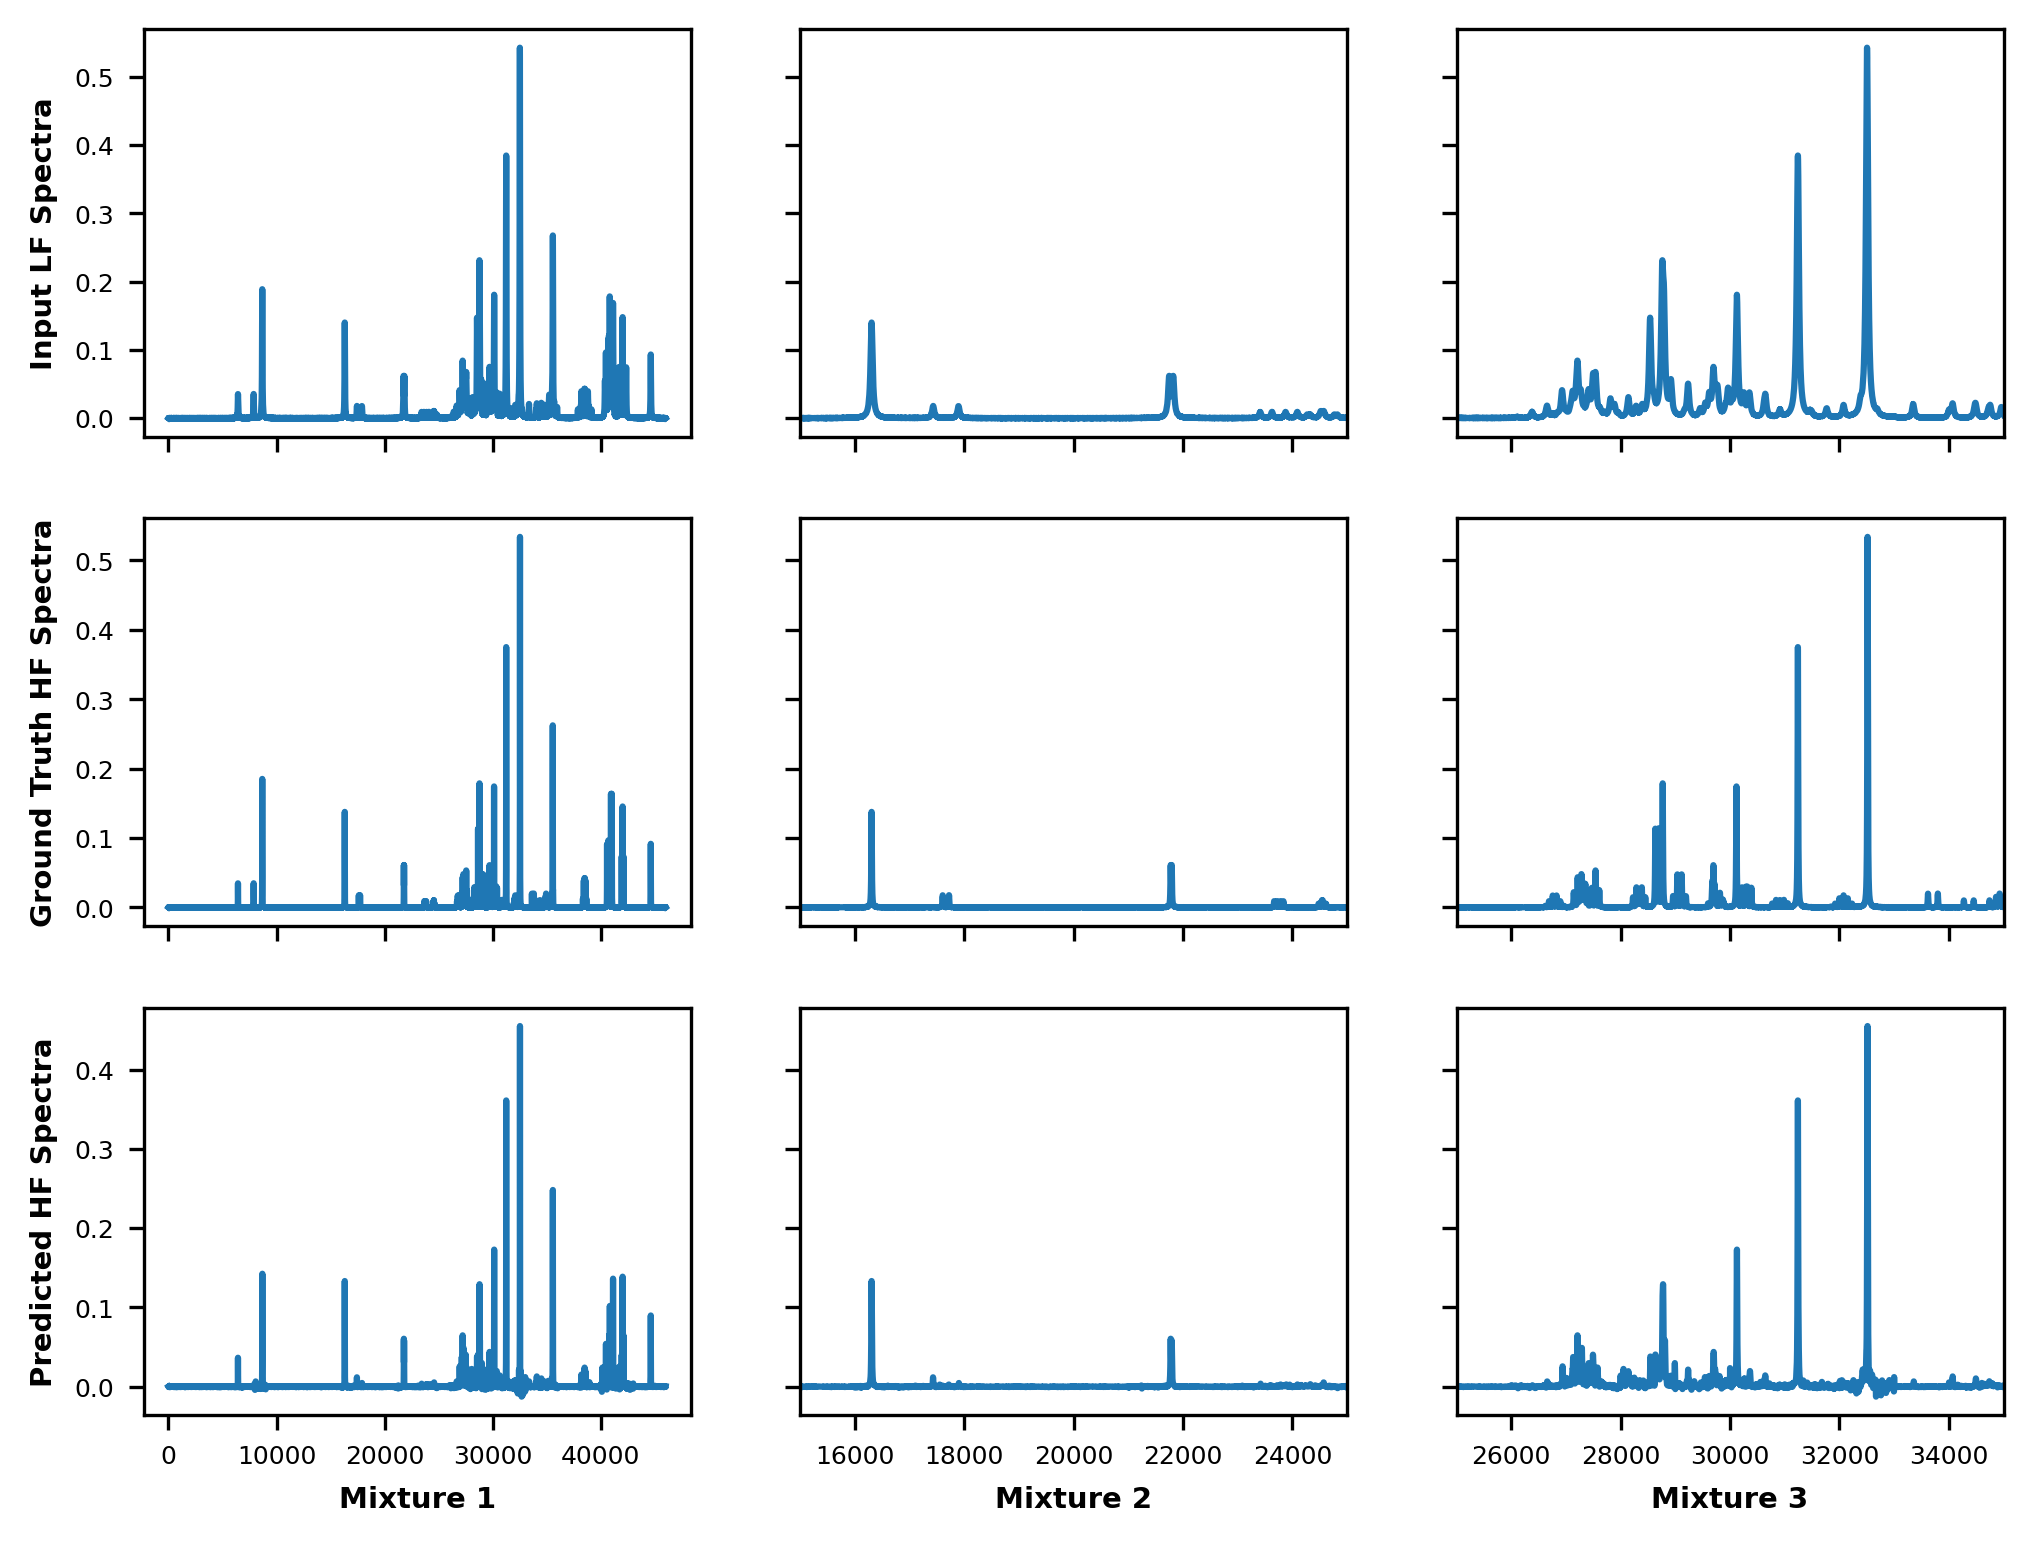

In [16]:
Predicted = model(spectra100_12NewMet[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(spectra100_12NewMet[0].cpu().detach().numpy())
#axs[0, 0].set_xlim([15000,25000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(spectra100_12NewMet[0].cpu().detach().numpy())
axs[0, 1].set_xlim([15000,25000])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(spectra100_12NewMet[0].cpu().detach().numpy())
axs[0, 2].set_xlim([25000,35000])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(spectra400_12NewMet[0].cpu().detach().numpy())
#axs[1, 0].set_xlim([15000,25000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(spectra400_12NewMet[0].cpu().detach().numpy())
axs[1, 1].set_xlim([15000,25000])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(spectra400_12NewMet[0].cpu().detach().numpy())
axs[1, 2].set_xlim([25000,35000])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
#axs[2, 0].set_xlim([15000,25000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([15000,25000])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([25000,35000])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')

count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

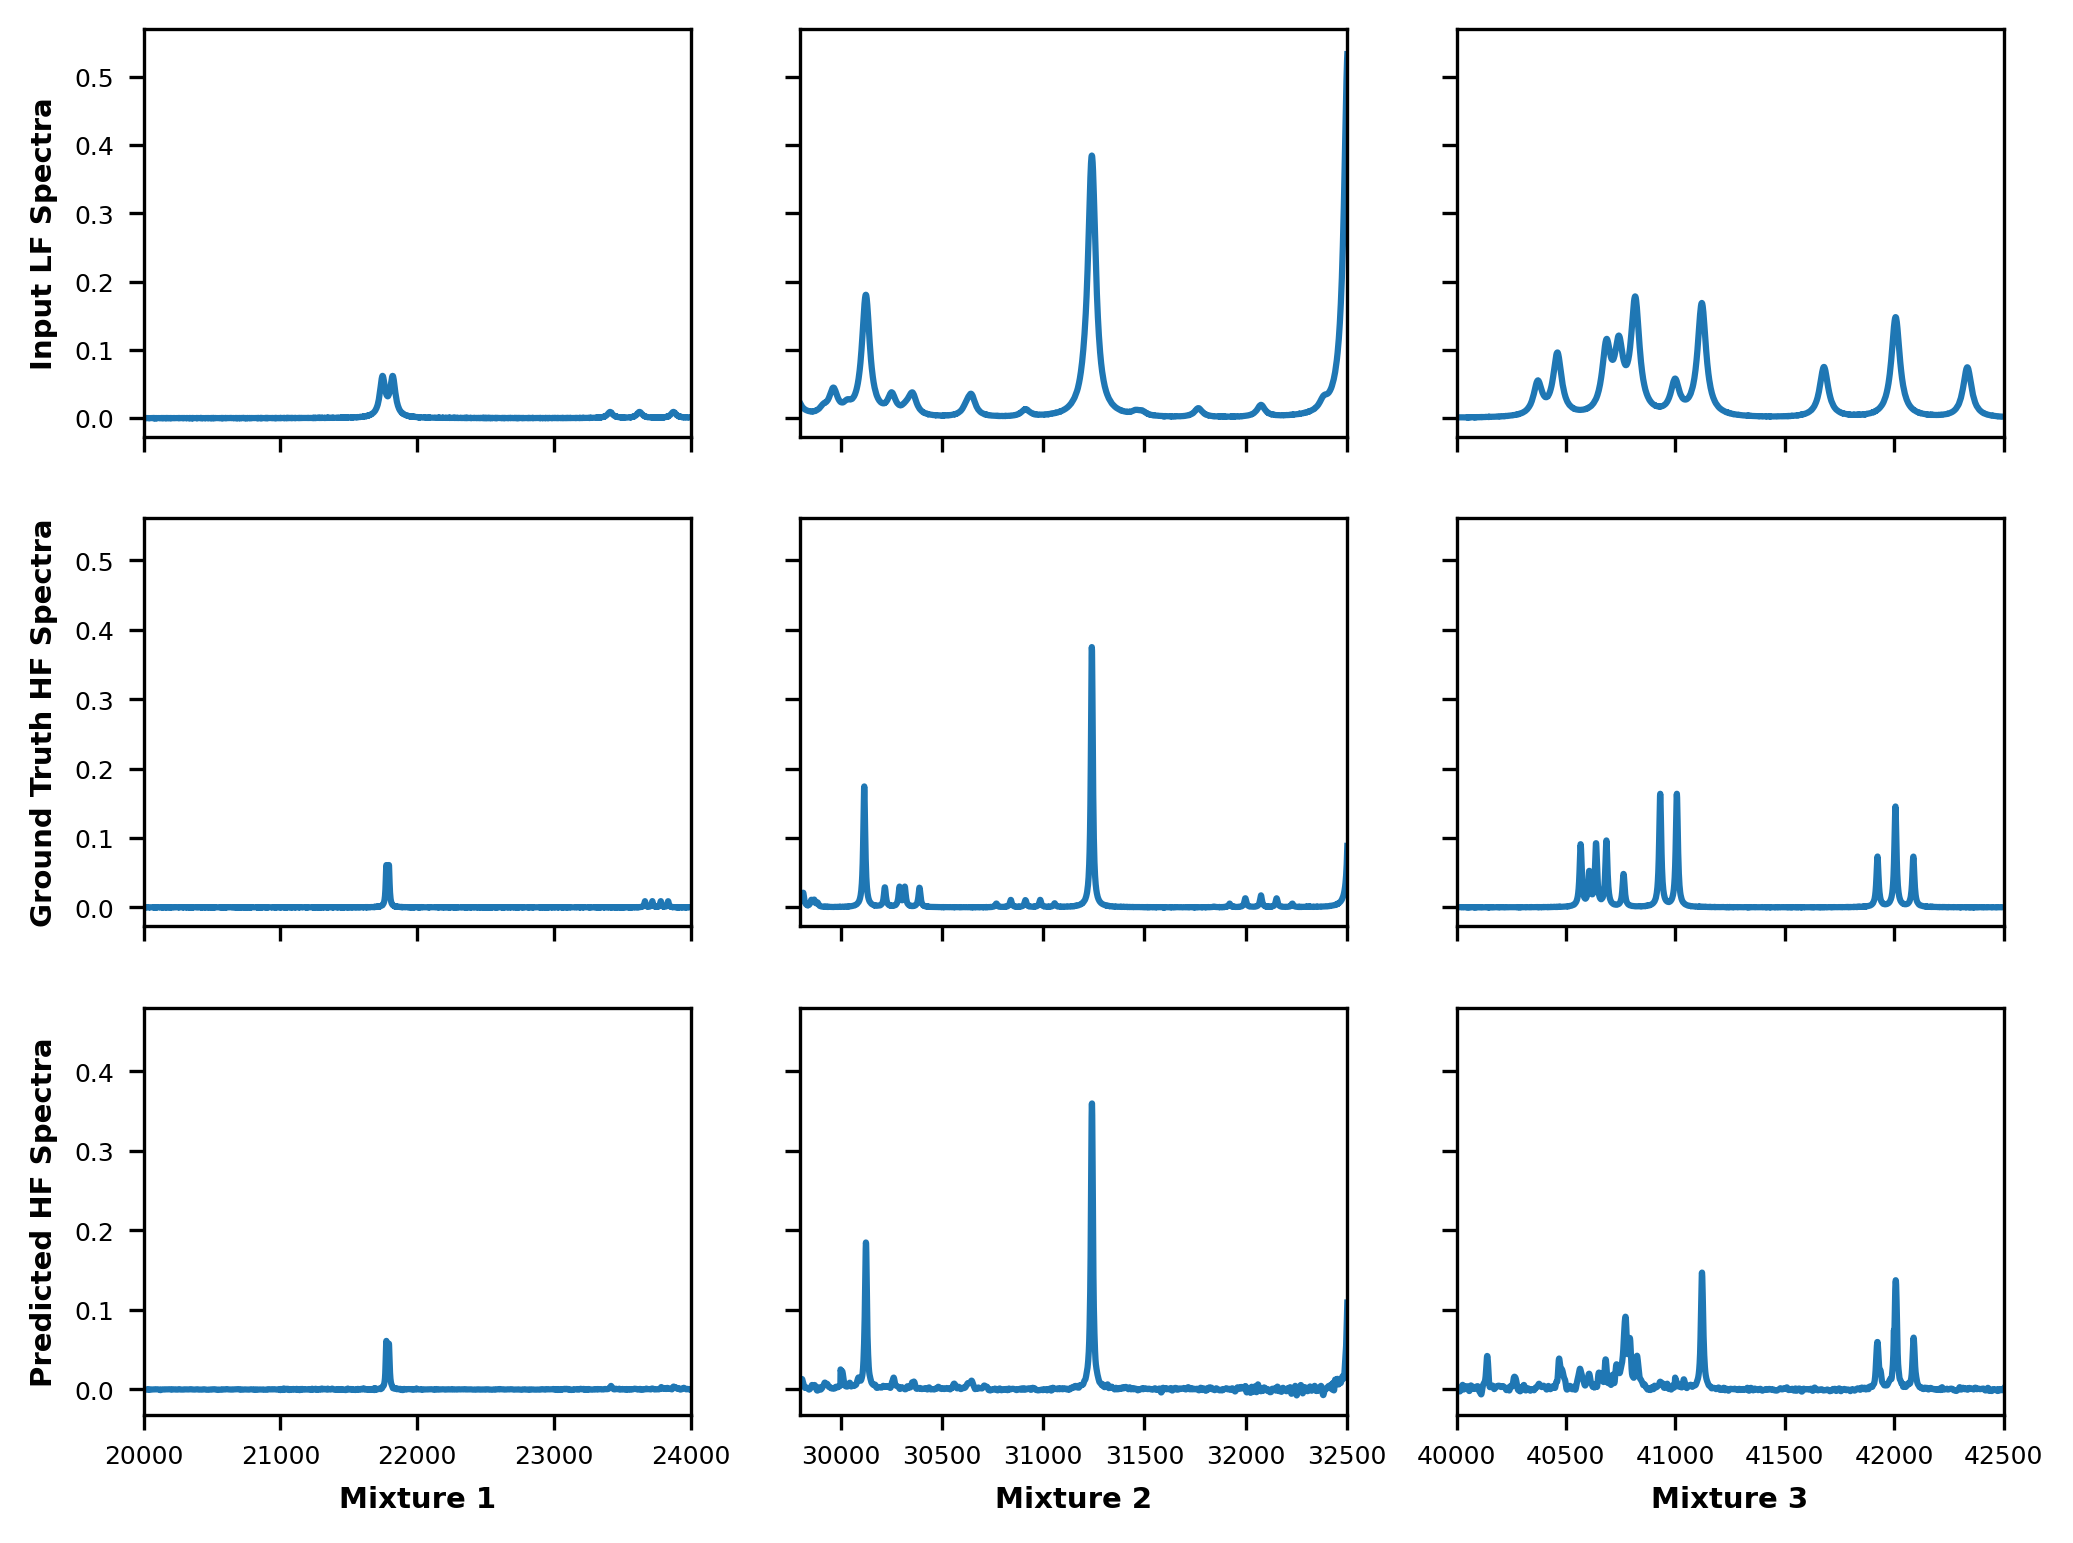

In [17]:
Predicted = model(spectra100_12NewMet[0].unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(spectra100_12NewMet[0].cpu().detach().numpy())
axs[0, 0].set_xlim([20000,24000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(spectra100_12NewMet[0].cpu().detach().numpy())
axs[0, 1].set_xlim([29800,32500])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(spectra100_12NewMet[0].cpu().detach().numpy())
axs[0, 2].set_xlim([40000,42500])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(spectra400_12NewMet[0].cpu().detach().numpy())
axs[1, 0].set_xlim([20000,24000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(spectra400_12NewMet[0].cpu().detach().numpy())
axs[1, 1].set_xlim([29800,32500])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(spectra400_12NewMet[0].cpu().detach().numpy())
axs[1, 2].set_xlim([40000,42500])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(Predicted)
axs[2, 0].set_xlim([20000,24000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(Predicted)
axs[2, 1].set_xlim([29800,32500])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(Predicted)
axs[2, 2].set_xlim([40000,42500])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Mixture 1","Mixture 1","Mixture 1","Mixture 2","Mixture 2","Mixture 2","Mixture 1","Mixture 2","Mixture 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

# Now train a model for quantification at low field and at high field, and compare LF-direct quantification to 'LF-to-HF prior to HF quantification'.

In [4]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
num_epochs = 1000
ModelName = "MLP_21Met_ForLFtoHF__HFmodel_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [5]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra400 = np.load('Dataset21_400MHz_AdjustSNR_Spec_ForQuant.npy')
conc1 = np.load('Dataset21_400MHz_AdjustSNR_Conc_ForQuant.npy')

# Load validation dataset
#spectraVal400 = np.load('Dataset21_400MHz_Val_Spec.npy')
#spectraValConc = np.load('Dataset21_Val_Conc.npy')

# Load representative validation spectra
RepSpectra400 = np.load("Dataset21_400MHz_AdjustSNR_RepresentativeExamples_Spectra.npy")
RepConc = np.load("Dataset21_AdjustSNR_RepresentativeExamples_Concentrations.npy")
RepSpecNames = np.load("Dataset21_AdjustSNR_RepresentativeExamples_VariableNames.npy")

In [6]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [7]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra400, conc1, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
RepSpectra400 = torch.tensor(RepSpectra400).float().to(device)

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
RepConc = torch.tensor(RepConc).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter400 = torch.utils.data.DataLoader(datasets, batch_size = 128, shuffle=True)
test_iter400 = torch.utils.data.DataLoader(Test_datasets, batch_size = 128, shuffle=True)

In [8]:
## Define NN model object, define some parameters, and instantiate model

# Define some model & training parameters
size_hidden1 = 200
size_hidden2 = 21
criterion = nn.MSELoss(reduction='sum')


# Define model
class NMR_Model_Aq(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(46000, size_hidden1)
        self.relu1 = nn.ReLU()
        self.lin2 = nn.Linear(size_hidden1, size_hidden2)
    def forward(self, input):
        return (self.lin2(self.relu1(self.lin1(input))))

In [20]:
def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)

        if (epoch + 1) % 50 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
        '''
        # Save model at specific epochs
        if epoch + 1 in [1000, 10000, 50000]:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, f'{save_path}_epoch_{epoch+1}.pt')
        '''

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            # Save model when test loss improves
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)

    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag


### Train HF MLP

In [9]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
num_epochs = 500
ModelName = "MLP_21Met_AdjustSNR_ForLFtoHF__HFmodel_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [12]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model_aq = NMR_Model_Aq()

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter400, test_iter400, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [50/500], Train Loss: 38969.2547, Test Loss: 19103.7366
Epoch [100/500], Train Loss: 25674.2379, Test Loss: 17681.2621
Epoch [150/500], Train Loss: 20092.9930, Test Loss: 17083.9409
Epoch [200/500], Train Loss: 17292.4104, Test Loss: 16929.5152
Epoch [250/500], Train Loss: 15782.1467, Test Loss: 16876.2752
Epoch [300/500], Train Loss: 14469.1291, Test Loss: 16981.4554
Epoch [350/500], Train Loss: 13550.8358, Test Loss: 17135.1134
Epoch [400/500], Train Loss: 12806.8348, Test Loss: 17533.7880
Epoch [450/500], Train Loss: 12343.0405, Test Loss: 17758.5391
Epoch [500/500], Train Loss: 11730.6630, Test Loss: 18071.6716
Execution time: 264.7990791797638 seconds


In [10]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_400 = NMR_Model_Aq()

# Load the model's state dictionary from the loaded dictionary
model_400.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_400.to(device)

NMR_Model_Aq(
  (lin1): Linear(in_features=46000, out_features=200, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=200, out_features=21, bias=True)
)

In [14]:
model_400(RepSpectra400[2])

tensor([[24.9659, 24.7493, 24.6903, 25.1481, 24.6954, 24.8187, 24.9288, 24.8145,
         24.4929, 24.9084, 24.4479, 24.4052, 24.8999, 24.6383, 24.6484, 24.8774,
         24.6655, 24.8483, 24.4282, 25.3377, 25.3402]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [15]:
RepConc[2]

tensor([25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25.], device='cuda:0')

### Train LF MLP

In [16]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
num_epochs = 1000
ModelName = "MLP_21Met_AdjustSNR_ForLFtoHF__LFmodel_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [17]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra100 = np.load('Dataset21_100MHz_Spec_ForQuant.npy')
conc1 = np.load('Dataset21_100MHz_Conc_ForQuant.npy')

# Load validation dataset
#spectraVal100 = np.load('Dataset21_400MHz_Val_Spec.npy')
#spectraValConc = np.load('Dataset21_Val_Conc.npy')

# Load representative validation spectra
RepSpectra100 = np.load("Dataset21_100MHz_RepresentativeExamples_Spectra.npy")
RepConc = np.load("Dataset21_RepresentativeExamples_Concentrations.npy")
RepSpecNames = np.load("Dataset21_RepresentativeExamples_VariableNames.npy")

In [18]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra100, conc1, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
RepSpectra100 = torch.tensor(RepSpectra100).float().to(device)

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
RepConc = torch.tensor(RepConc).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter100 = torch.utils.data.DataLoader(datasets, batch_size = 128, shuffle=True)
test_iter100 = torch.utils.data.DataLoader(Test_datasets, batch_size = 128, shuffle=True)

In [21]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model_aq = NMR_Model_Aq()

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter100, test_iter100, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [50/1000], Train Loss: 61294.6683, Test Loss: 21715.5376
Epoch [100/1000], Train Loss: 40124.8688, Test Loss: 16243.7126
Epoch [150/1000], Train Loss: 33229.0248, Test Loss: 14655.3755
Epoch [200/1000], Train Loss: 29032.0013, Test Loss: 13565.8785
Epoch [250/1000], Train Loss: 24932.1231, Test Loss: 12191.9363
Epoch [300/1000], Train Loss: 21904.1997, Test Loss: 10948.7405
Epoch [350/1000], Train Loss: 20129.5262, Test Loss: 10365.9170
Epoch [400/1000], Train Loss: 18900.5779, Test Loss: 10235.0087
Epoch [450/1000], Train Loss: 16678.5240, Test Loss: 9473.5888
Epoch [500/1000], Train Loss: 15838.3242, Test Loss: 8827.3383
Epoch [550/1000], Train Loss: 14813.5020, Test Loss: 8682.9182
Epoch [600/1000], Train Loss: 14128.5257, Test Loss: 8535.6301
Epoch [650/1000], Train Loss: 12744.6910, Test Loss: 7921.1320
Epoch [700/1000], Train Loss: 11844.0088, Test Loss: 7646.1321
Epoch [750/1000], Train Loss: 11084.2818, Test Loss: 7430.241

In [22]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_100 = NMR_Model_Aq()

# Load the model's state dictionary from the loaded dictionary
model_100.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_100.to(device)

NMR_Model_Aq(
  (lin1): Linear(in_features=46000, out_features=200, bias=True)
  (relu1): ReLU()
  (lin2): Linear(in_features=200, out_features=21, bias=True)
)

In [23]:
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')
RepSpecNames = np.load("Dataset87_AdjustSNR_RepresentativeExamples_VariableNames.npy")

In [31]:
## Compute MAPE for all models on representative example spectra



## MAPE for 100-MHz model
APEs = []
MAPEs_100 = []

for i in np.arange(10):
    GroundTruth = RepConc[i]
    Prediction = model_100(RepSpectra100[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(21):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs_100.append(round(MAPE.item(),2))
    
    

    
## MAPE for 400-MHz model
APEs = []
MAPEs_400 = []

for i in np.arange(10):
    GroundTruth = RepConc[i]
    Prediction = model_400(RepSpectra400[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(21):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs_400.append(round(MAPE.item(),2))
    
    
    
    
    
    
## MAPE for 400-MHz model on 100-MHz data converted to 400-MHz
APEs = []
MAPEs_LFtoHF = []

for i in np.arange(10):
    GroundTruth = RepConc[i]
    Prediction = model_400(model(RepSpectra100[i]))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(21):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs_LFtoHF.append(round(MAPE.item(),2))
    
    

    
    

# Convert lists to numpy arrays and save
#np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs_100))


In [32]:
modelList = ['Model Input', "100-MHz", "400-MHz", "LF-to-HF"]

for i in np.arange(10):
    print(RepSpecNames[i], MAPEs_100[i],MAPEs_400[i], MAPEs_LFtoHF[i])

AllAq1 76.33 35.8 62.46
AllAq5 3.97 6.26 8.6
AllAq25 0.55 1.12 1.38
AllAq50 0.69 0.84 1.24
ThreeAddedSinglets 1.12 4.77 5.19
ThirtyAddedSinglets 5.07 13.56 13.81
ShiftedSpec 82.06 81.23 81.34
SineBase 41.98 11.34 3.71
HighDynamicRange 773.16 370.69 390.62
HalfZeros inf inf inf


In [34]:
import pandas as pd

# Create DataFrame
data = {
    'Inputs': RepSpecNames[:5],
    '100-MHz': MAPEs_100[:5],
    '400-MHz': MAPEs_400[:5],
    'LF-to-HF': MAPEs_LFtoHF[:5],
}

df = pd.DataFrame(data)

# Set 'Names' as index
df.set_index('Inputs', inplace=True)

df 


,100-MHz,400-MHz,LF-to-HF
Inputs,,,
AllAq1,76.33,35.80,62.46
AllAq5,3.97,6.26,8.60
AllAq25,0.55,1.12,1.38
AllAq50,0.69,0.84,1.24
ThreeAddedSinglets,1.12,4.77,5.19


In [21]:
model_100(RepSpectra100[2])

tensor([[25.0220, 25.0084, 25.3946, 25.0008, 25.3515, 25.3091, 25.0895, 25.1706,
         24.7430, 24.9499, 25.1157, 25.0783, 25.2636, 24.8569, 24.8006, 24.6115,
         24.9976, 24.9179, 24.9462, 24.8682, 25.2477]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [22]:
model_400(RepSpectra400[2])

tensor([[24.9659, 24.7493, 24.6903, 25.1481, 24.6954, 24.8187, 24.9288, 24.8145,
         24.4929, 24.9084, 24.4479, 24.4052, 24.8999, 24.6383, 24.6484, 24.8774,
         24.6655, 24.8483, 24.4282, 25.3377, 25.3402]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [23]:
model_400(RepSpectra100[2])

tensor([[79.1592, 77.0922, 90.2086, 79.2625, 88.9957, 93.5728, 32.6962, 88.7691,
         75.4417, 84.4985, 24.6621, 79.2677, 81.2404, 62.9583, 82.6106, 73.4049,
         55.2668, 47.3596, 54.0255, 62.2238, 57.2828]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [28]:
model_400(model(RepSpectra100[2]))

tensor([[25.1863, 25.0039, 24.4175, 24.9935, 25.3880, 25.3911, 25.2157, 25.0328,
         24.5788, 25.6678, 24.5260, 24.4189, 25.2528, 24.6422, 24.6015, 25.0703,
         24.2631, 24.9602, 24.5587, 24.1032, 24.4974]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [29]:
RepConc[2]

tensor([25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25.], device='cuda:0')

In [30]:
model_100(RepSpectra100[0])

tensor([[ 1.0326,  0.8786,  1.2145,  1.4680, -1.1138, -0.0296,  0.5529,  0.5595,
          2.0064,  1.8268,  1.2461,  0.9910,  1.7306,  1.9761, -1.2196,  1.6530,
          2.0465,  1.3632,  1.4942,  1.1278,  1.5824]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [31]:
model_400(RepSpectra400[0])

tensor([[ 0.9355,  1.1233,  1.2178,  1.2098, -0.3844,  0.3044,  0.8127,  1.3705,
          0.7569,  0.6882,  0.7737,  1.3198,  1.3188,  1.2465,  0.0452,  1.1909,
          1.0878,  1.4589,  1.0760,  1.6413,  1.1894]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [32]:
model_400(RepSpectra100[0])

tensor([[ 8.8309,  8.3219,  8.1741, 11.9450,  6.7612,  7.6577,  7.8972, 11.5545,
         11.0380,  3.4482,  5.5525,  8.9064, 11.3265,  8.4488, 11.5260,  8.5346,
          4.3542,  6.2693,  4.1135,  0.4422,  4.0952]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [33]:
model_400(model(RepSpectra100[0]))

tensor([[ 0.5213,  0.8482,  0.4328,  1.0125, -1.6225, -0.4560,  0.5913,  1.0736,
          0.6141,  0.3456,  0.6021,  1.3764,  0.8063,  0.8952, -0.9865,  0.9586,
          0.4513,  1.6630,  0.4617,  1.8769,  0.9241]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [34]:
RepConc[0]

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.], device='cuda:0')

In [35]:
model_100(RepSpectra100[1])

tensor([[4.8206, 4.7709, 5.0812, 4.8016, 4.8633, 4.8641, 4.7823, 4.8102, 4.8617,
         4.8940, 4.9072, 4.9434, 4.7967, 4.9638, 4.7479, 4.6795, 4.9469, 4.6747,
         4.8013, 4.9108, 5.0439]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [36]:
model_400(RepSpectra400[1])

tensor([[4.6277, 4.7136, 4.7194, 4.6886, 4.8607, 4.9317, 4.5984, 4.6662, 4.4128,
         4.7274, 4.5557, 4.5697, 4.5700, 4.6447, 4.6396, 4.7338, 4.7263, 4.6742,
         4.5360, 5.0379, 4.8639]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [37]:
model_400(RepSpectra100[1])

tensor([[20.3804, 19.7292, 21.6549, 22.9662, 21.1763, 21.9223, 11.8468, 24.4310,
         21.6907, 17.0550,  8.7668, 20.2194, 22.8784, 17.2639, 24.2022, 19.5212,
         12.9704, 12.8790, 12.2155, 10.1397, 12.6716]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [38]:
model_400(model(RepSpectra100[1]))

tensor([[4.6025, 4.6519, 4.2804, 4.3691, 4.9225, 5.2482, 4.1027, 4.4063, 4.6821,
         4.5400, 4.4409, 4.4860, 4.5052, 4.4654, 5.0287, 4.9303, 4.3165, 4.4965,
         4.1167, 4.4650, 4.9737]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [39]:
RepConc[1]

tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5.], device='cuda:0')

In [40]:
model_100(RepSpectra100[8])

tensor([[ -0.0986,  44.8756,   7.0506,  51.4588, -53.4531,  18.8414,  -8.9871,
          30.8062,  17.2231,  64.9145,   3.2932,  50.5684,  11.1915,  61.5946,
         -54.0545,  61.2547,  17.8185,  57.0008,   9.4442,  49.8921,  10.0672]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [41]:
model_400(RepSpectra400[8])

tensor([[ -4.7902,  47.6175,   0.3444,  46.7290, -22.3670,  35.9349,  -5.3328,
          49.1607,  -5.4991,  47.8865,  -5.5035,  51.9605,  -1.7781,  51.2342,
         -21.3976,  50.8995,   2.0801,  51.6119,   0.6581,  59.9056,   2.3325]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [42]:
model_400(RepSpectra100[8])

tensor([[139.9187, 246.2232, 135.0906, 317.8869,  96.0688, 237.2517, 152.9615,
         307.0959, 193.4999, 107.7343, 115.6138, 206.0139, 194.7226, 217.9909,
         199.5262, 233.9972,  98.7450, 123.7575,  77.3250,  19.5364,  63.6364]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [43]:
model_400(model(RepSpectra100[8]))

tensor([[10.3558, 60.0140,  8.0221, 66.8618,  6.9937, 57.5334, 12.6275, 66.4490,
         14.3783, 51.2851,  7.9597, 59.8951, 14.8089, 60.6011, 16.1613, 61.5069,
          4.5951, 57.7002,  3.5617, 45.7817,  3.6378]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [44]:
RepConc[8]

tensor([ 1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,  1., 50.,
         1., 50.,  1., 50.,  1., 50.,  1.], device='cuda:0')